# Table of Contents
 <p><div class="lev1 toc-item"><a href="#All-simulations" data-toc-modified-id="All-simulations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>All simulations</a></div><div class="lev2 toc-item"><a href="#A-few-examples" data-toc-modified-id="A-few-examples-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>A few examples</a></div><div class="lev2 toc-item"><a href="#now-do-all-of-them" data-toc-modified-id="now-do-all-of-them-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>now do all of them</a></div><div class="lev2 toc-item"><a href="#Distribution-of-fitted-hyperparameters" data-toc-modified-id="Distribution-of-fitted-hyperparameters-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Distribution of fitted hyperparameters</a></div><div class="lev1 toc-item"><a href="#Pushing-the-trend-into-the-kernel" data-toc-modified-id="Pushing-the-trend-into-the-kernel-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pushing the trend into the kernel</a></div>

In [1]:
using DataFrames
using GaussianProcesses
using Distributions
using GaussianProcesses: predict, get_params

using LaTeXStrings
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [185]:
include("src/GeoRDD.jl")

GeoRDD

In [3]:
_simdata=readtable("saved_simData/lee_5.csv", header=true, names=[:i,:x,:y]);

In [4]:
lee_left(x::Real) = 0.48 + 1.27 * x + 7.18*x^2 + 20.21*x^3 + 21.54*x^4 + 7.33*x^5
lee_right(x::Real) = 0.52 + 0.84 * x - 3.00*x^2 + 7.99*x^3  - 9.01*x^4 + 3.56*x^5
function lee_truth(x::Real)
    if x<zero(x)
        return lee_left(x)
    else
        return lee_right(x)
    end
end

lee_truth (generic function with 1 method)

In [5]:
xx=linspace(-1.0,1.0,1000);

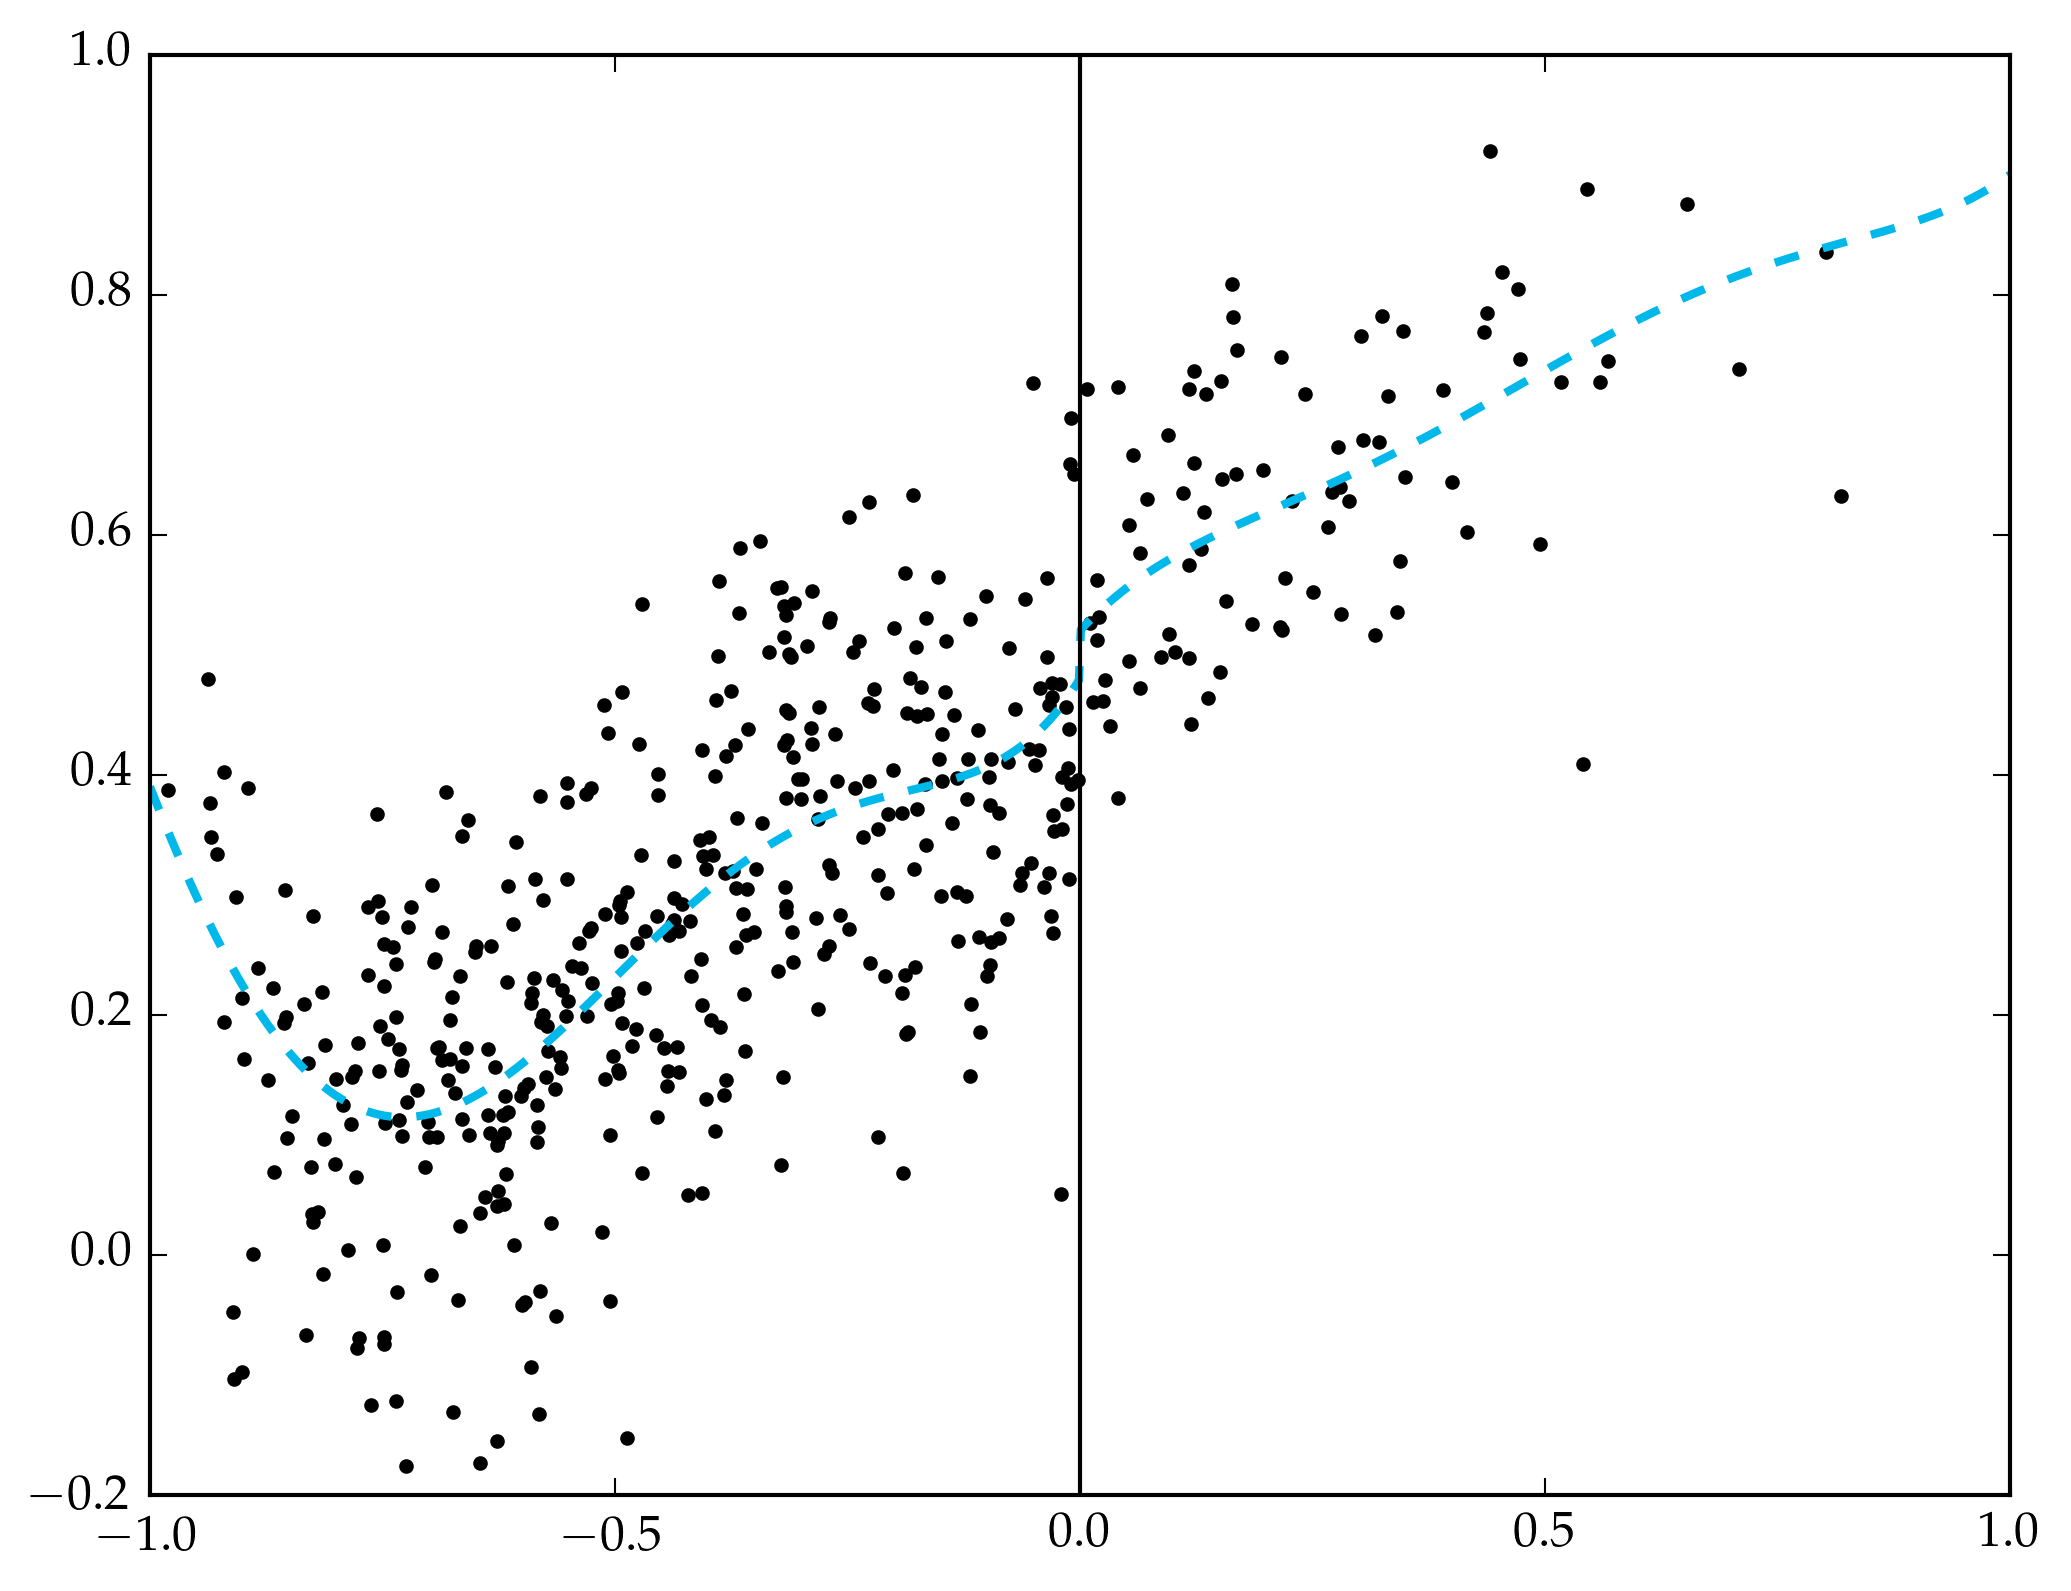

In [6]:
plt.plot(_simdata[:x].values, _simdata[:y].values, ".", color="black", label="simulated data")
plt.plot(xx, lee_truth.(xx), "--", color="#00B8EA", linewidth=2, label="truth")
plt.axvline(0.0, color="black")
;

In [7]:
_kern = SEIso(-3.0, -3.0)
_meanf1 = MeanLin([0.0])+MeanConst(0.0)
_meanf2 = MeanLin([0.0])+MeanConst(0.0)
_X = _simdata[:x].values'
_right= vec(_X) .> 0.0
_Y = _simdata[:y].values
_gp_right=GP(_X[:,_right],  _Y[_right],  _meanf1, _kern, 0.0)
_gp_left =GP(_X[:,!_right], _Y[!_right], _meanf2, _kern, 0.0)

GP object:
  Dim = 1
  Number of observations = 416
  Mean function:
    Type: GaussianProcesses.SumMean
      Type: GaussianProcesses.MeanLin, Params: [0.0]
      Type: GaussianProcesses.MeanConst, Params: [0.0]
  Kernel:
    Type: GaussianProcesses.SEIso, Params: [-3.0,-3.0]
  Input observations = 
[-0.980896 -0.937369 … -0.00681883 -0.00217726]
  Output observations = [0.386936,0.479321,0.376609,0.348104,0.334052,0.194024,0.401803,-0.0481022,-0.103552,0.298374  …  0.456425,0.375832,0.405334,0.438114,0.313108,0.658657,0.392569,0.696798,0.650467,0.395658]
  Variance of observation noise = 1.0
  Marginal Log-Likelihood = -401.407

In [8]:
_both_gps = GeoRDD.GPRealisations([_gp_right, _gp_left]);

In [9]:
using Calculus
using GaussianProcesses: update_mll_and_dmll!

In [10]:
update_mll_and_dmll!(_both_gps);

In [11]:
func=GeoRDD.get_optim_target(_both_gps)

Optim.DifferentiableFunction(GeoRDD.mll,GeoRDD.dmll!,GeoRDD.mll_and_dmll!)

In [12]:
Calculus.gradient(func.f, get_params(_both_gps))

7-element Array{Float64,1}:
 432.726  
 -13.6949 
 -51.1353 
  34.3727 
 -97.5952 
  -2.22474
  -3.68622

In [13]:
-_both_gps.dmLL

7-element Array{Float64,1}:
 432.726  
 -13.6949 
 -51.1353 
  34.3727 
 -97.5952 
  -2.22474
  -3.68622

In [14]:
optimize!(_both_gps)

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [0.0,0.0, ...]
 * Minimizer: [-2.0870346411985503,0.3010997245617437, ...]
 * Minimum: -3.216486e+02
 * Iterations: 84
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: true
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 295
 * Gradient Calls: 211

In [15]:
τtrue = lee_right(0.0)-lee_left(0.0)

0.040000000000000036

In [16]:
_τposterior2D=GeoRDD.cliff_face(_gp_right, _gp_left, zeros(1,1))
_μpost  = _τposterior2D[1][1]
_σ2post = _τposterior2D[2].mat[1]
_τposterior = Normal(_μpost, √_σ2post)

Distributions.Normal{Float64}(μ=-0.10652213536782662, σ=0.0387648595060682)

In [17]:
quantile(_τposterior, 0.025) < τtrue < quantile(_τposterior, 0.975)

false

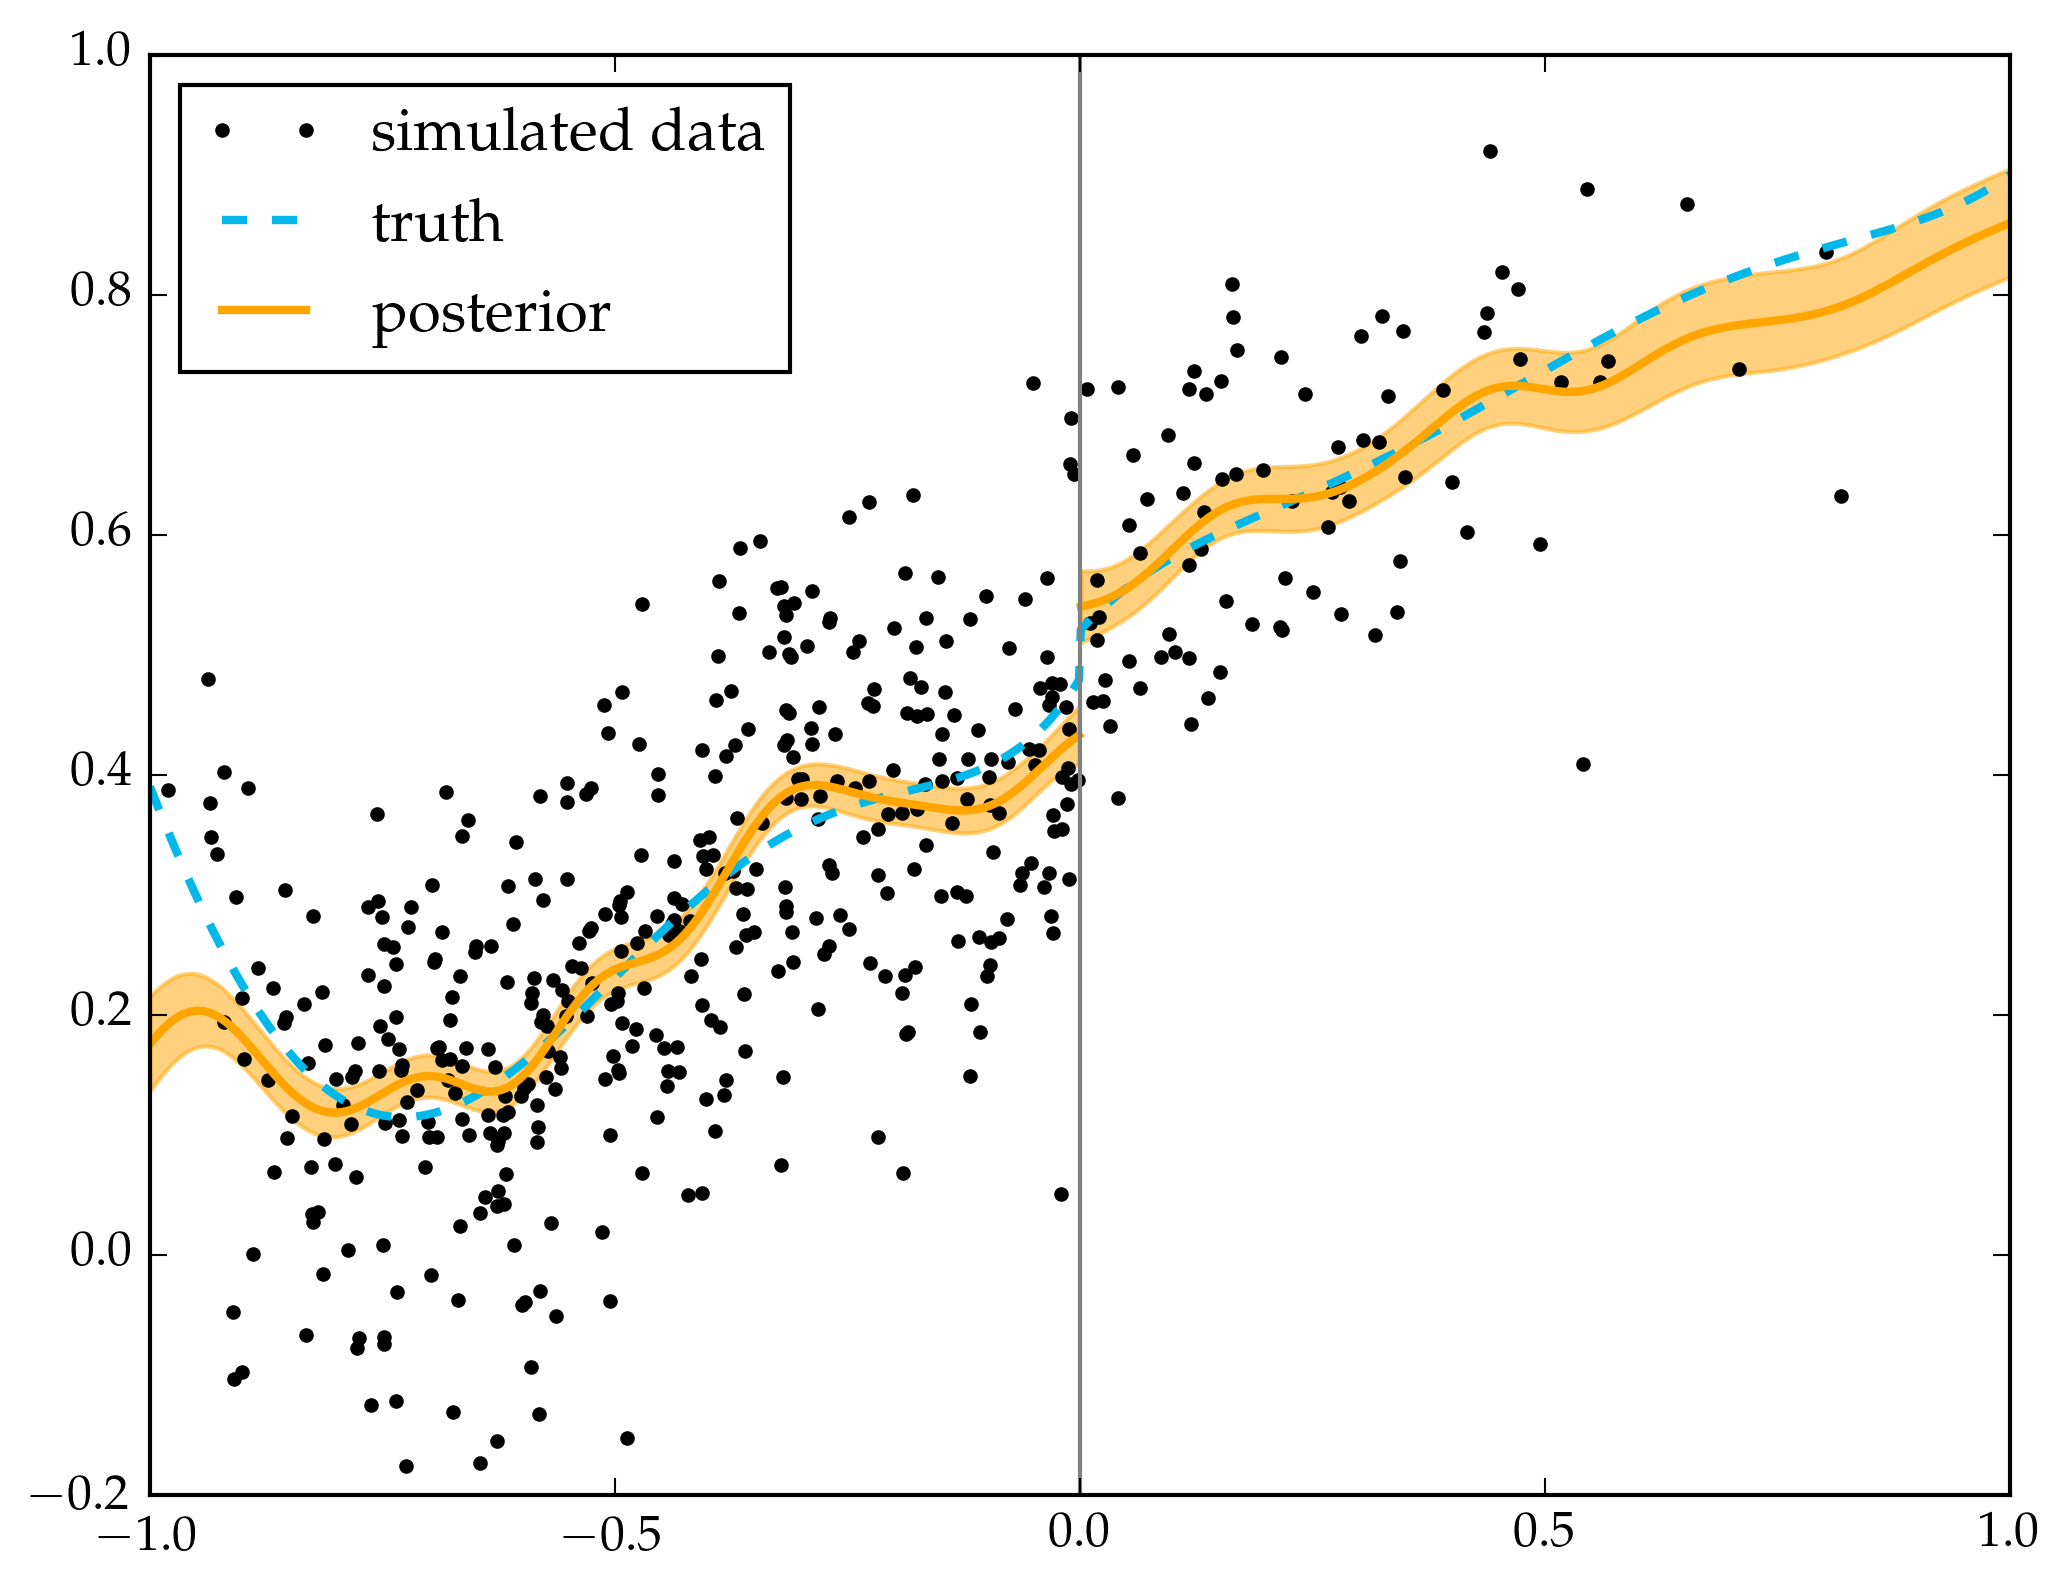

In [18]:
begin
    xx_left = xx[xx.<0]
    xx_right = xx[xx.>0]
    pred_left = predict(_gp_left, xx_left'; full_cov=false)
    pred_right = predict(_gp_right, xx_right'; full_cov=false)
    
    plt.plot(_simdata[:x].values, _simdata[:y].values, ".", color="black", label="simulated data")
    plt.plot(xx, lee_truth.(xx), "--", color="#00B8EA", linewidth=2, label="truth")
    plt.plot(xx_left, pred_left[1], 
        color="orange", linewidth=2, label="posterior")
    plt.fill_between(xx_left, pred_left[1].-√pred_left[2], pred_left[1].+√pred_left[2], 
        color="orange", alpha=0.5)
    plt.plot(xx_right, pred_right[1], color="orange", linewidth=2)
    plt.fill_between(xx_right, pred_right[1].-√pred_right[2], pred_right[1].+√pred_right[2], 
        color="orange", alpha=0.5)
    plt.axvline(0.0, color="grey")
    plt.legend(loc="upper left")
end;

# All simulations

In [19]:
function fit_2GP(x::Vector, y::Vector, thresh::Real)
    # specify kernel and mean function
    kern = SEIso(-3.0, -3.0)
    right = x .> thresh
    meanf_l = MeanLin([0.0])+MeanConst(mean(y[!right]))
    meanf_r = MeanLin([0.0])+MeanConst(mean(y[right]))
    
    # create GPs for left and right
    gp_left  =GP(x[!right]', y[!right], meanf_l, kern, 0.0)
    gp_right =GP(x[right]',  y[right],  meanf_r, kern, 0.0)
    both_gps = GeoRDD.GPRealisations([gp_left, gp_right])
    
    # optimize hyperparameters
    optimize!(both_gps)
    return both_gps
end

fit_2GP (generic function with 1 method)

In [20]:
function get_τpost(gp_left::GP, gp_right::GP, thresh::Real)
    τposterior2D=GeoRDD.cliff_face(gp_left, gp_right, thresh*ones(1,1))
    μpost = τposterior2D[1][1]
    σ2post = τposterior2D[2].mat[1]
    τposterior = Normal(μpost, √σ2post)
    return τposterior
end
function get_τpost_2GP(x::Vector, y::Vector, thresh::Real)
    both_gps = fit_2GP(x,y,thresh)
    gp_left, gp_right = both_gps.reals
    # get treatment effect estimate at the boundary
    τposterior = get_τpost(gp_left, gp_right, thresh)
    return τposterior
end

get_τpost_2GP (generic function with 1 method)

In [21]:
type Fitted2GP
    τpost::Normal
    hyp::Vector{Float64}
end
    
function do_sim(sim::String, isim::Int, thresh::Real)
    simdata=readtable(@sprintf("saved_simData/%s_%d.csv", sim, isim), header=true, names=[:i,:x,:y]);
    both_gps = fit_2GP(simdata[:x].values, simdata[:y].values, thresh)
    gp_left, gp_right = both_gps.reals
    τpost = get_τpost(gp_left, gp_right, thresh)
    return Fitted2GP(τpost, get_params(both_gps))
end

do_sim (generic function with 1 method)

In [22]:
@time do_sim("lee", 1, 0.0)

  8.135698 seconds (2.35 M allocations: 128.373 MB, 0.33% gc time)


Fitted2GP(Distributions.Normal{Float64}(μ=0.03467102728098376, σ=0.029392092810983952),[-1.99828,0.38077,0.458251,0.44075,0.509505,-2.30348,-3.54551])

In [23]:
function plot_sim(sim::String, isim::Int, thresh::Real)
    simdata=readtable(@sprintf("saved_simData/%s_%d.csv", sim, isim), header=true, names=[:i,:x,:y]);
    x = simdata[:x].values
    y = simdata[:y].values
    both_gps = fit_2GP(x, y, thresh)
    gp_left, gp_right = both_gps.reals
    τpost = get_τpost(gp_left, gp_right, thresh)
    xx=linspace(-1.0,1.0,1000)
    xx_left = xx[xx.<thresh]
    xx_right = xx[xx.>thresh]
    pred_left = predict(gp_left, xx_left'; full_cov=false)
    pred_right = predict(gp_right, xx_right'; full_cov=false)

    plt.plot(x, y, ".", color="black", label="simulated data")
    plt.plot(xx, lee_truth.(xx), "--", color="#00B8EA", linewidth=2, label="truth")
    plt.plot(xx_left, pred_left[1], 
        color="orange", linewidth=2, label="posterior")
    plt.fill_between(xx_left, pred_left[1].-2.0*√pred_left[2], pred_left[1].+√pred_left[2], 
        color="orange", alpha=0.5)
    plt.plot(xx_right, pred_right[1], color="orange", linewidth=2)
    plt.fill_between(xx_right, pred_right[1].-2.0*√pred_right[2], pred_right[1].+√pred_right[2], 
        color="orange", alpha=0.5)
    plt.axvline(0.0, color="grey")
    plt.legend(loc="upper left")
    plt.text(0.2, 0.0, latexstring(@sprintf("\$\\tau \\mid Y \\sim \\mathcal{N}(%.3f,\\sigma=%.3f)\$", mean(τpost), std(τpost))))
    cover = quantile(τpost, 0.025) < τtrue < quantile(τpost, 0.975)
    plt.text(0.2, 0.1, @sprintf("covers? %s", cover ? "yes" : "no"))
end

plot_sim (generic function with 1 method)

## A few examples

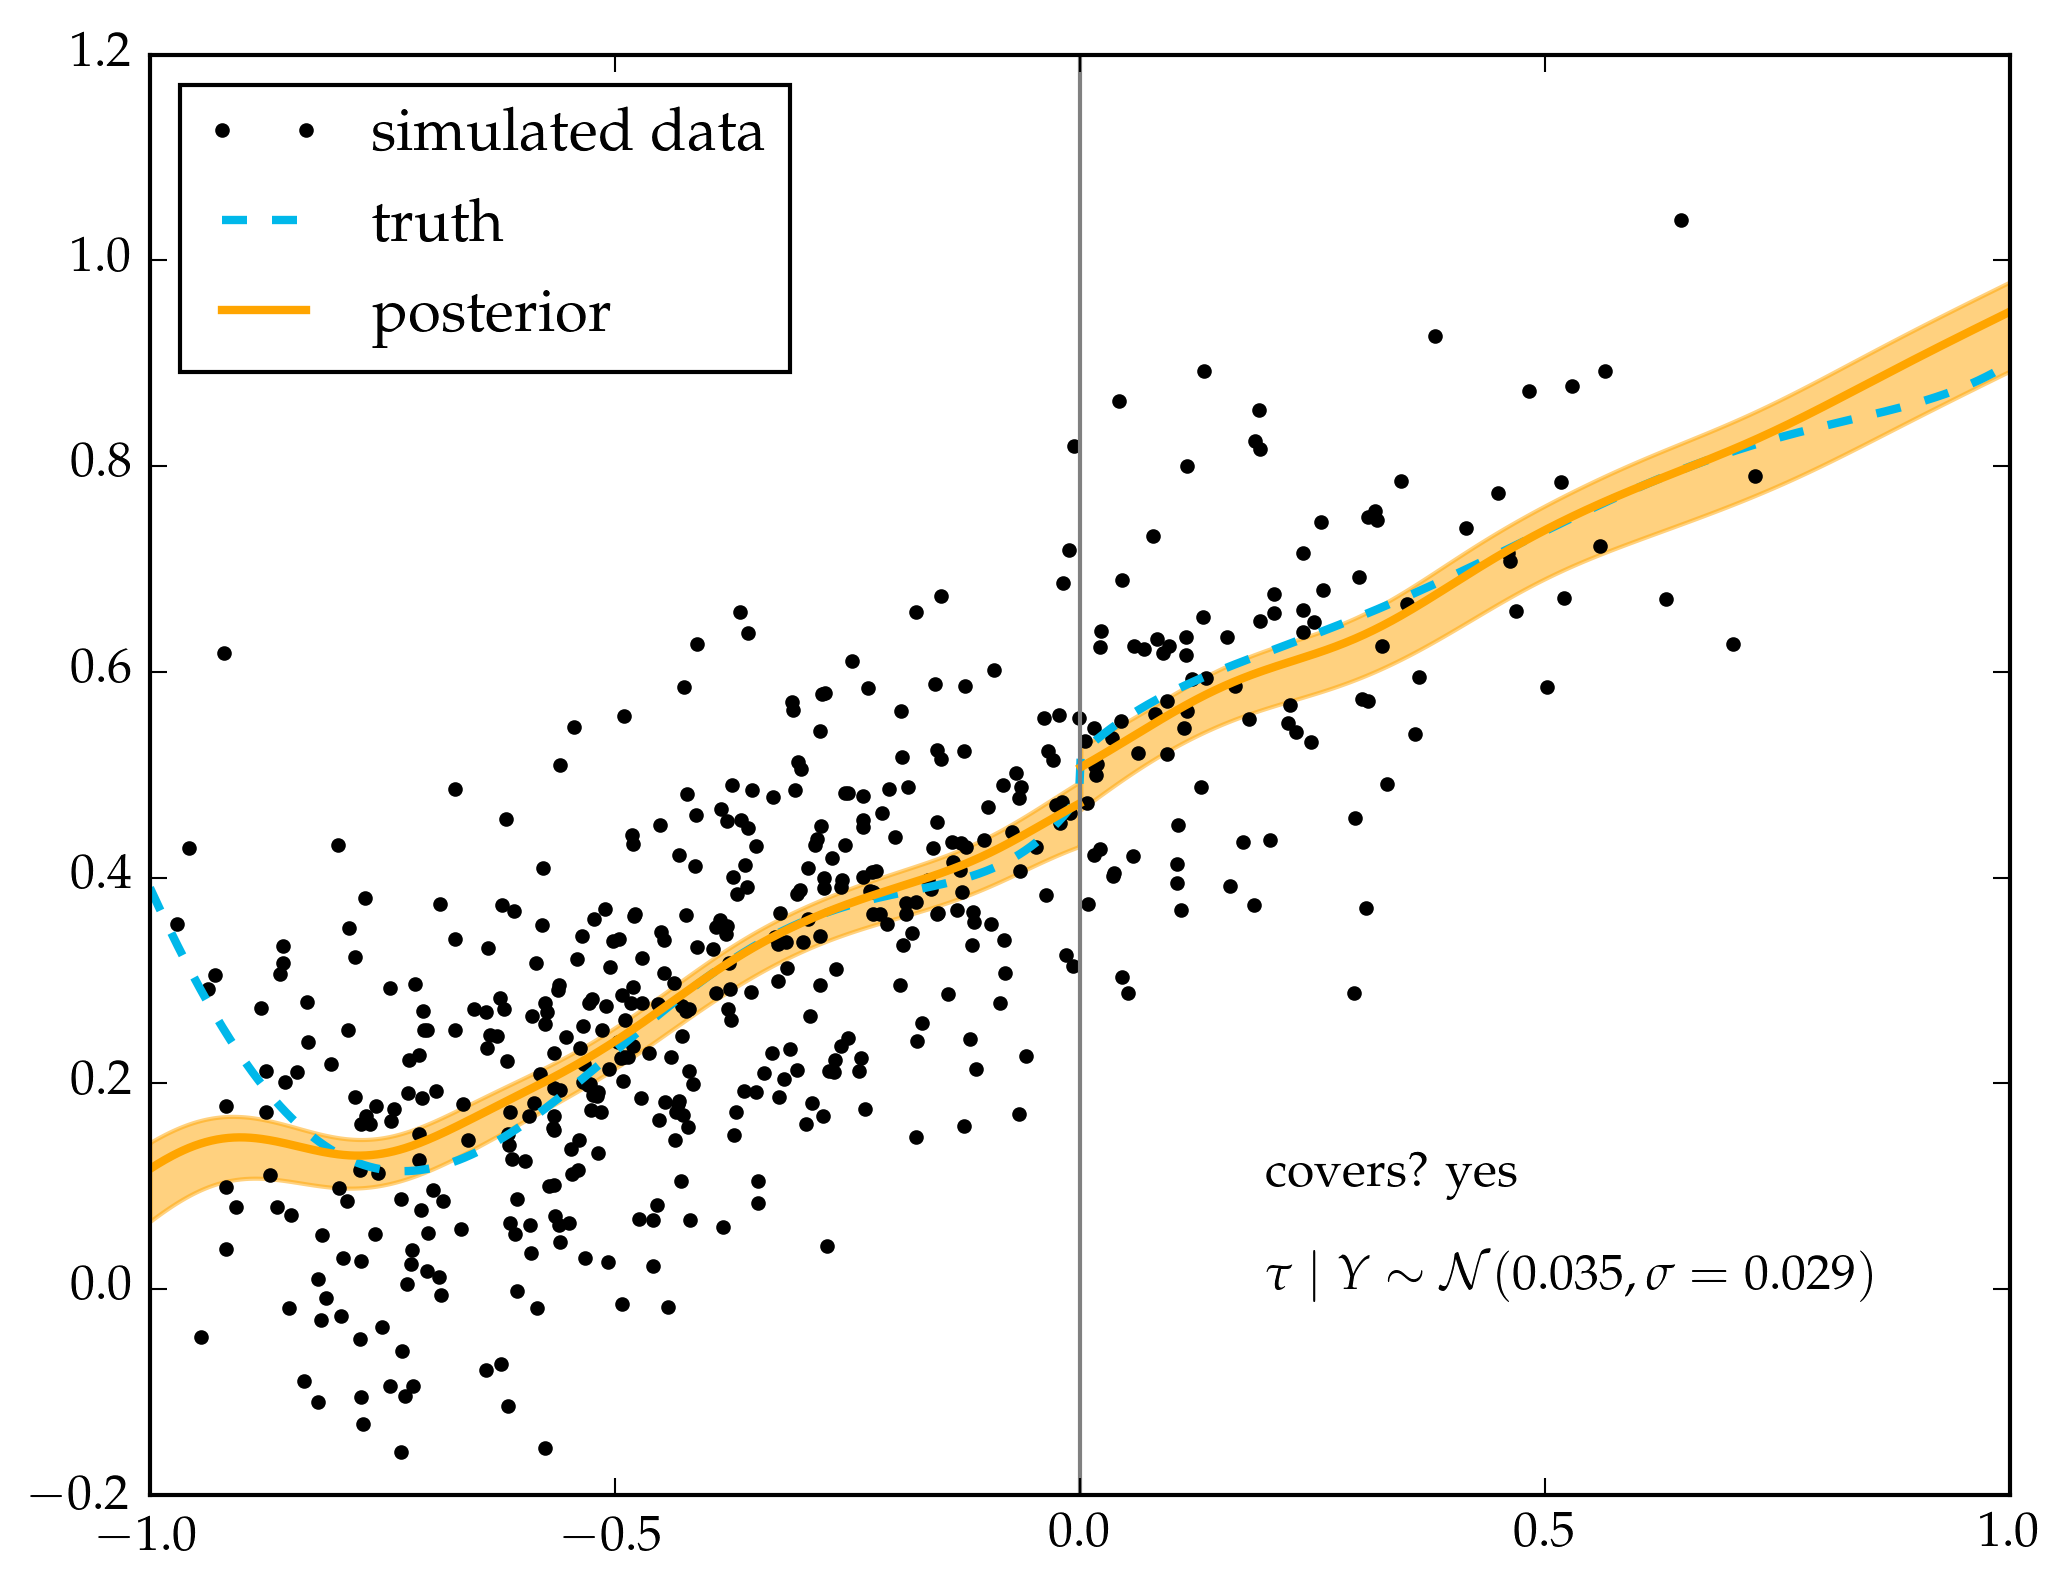

PyObject <matplotlib.text.Text object at 0x31e78fa50>

In [24]:
plot_sim("lee", 1, 0.0)

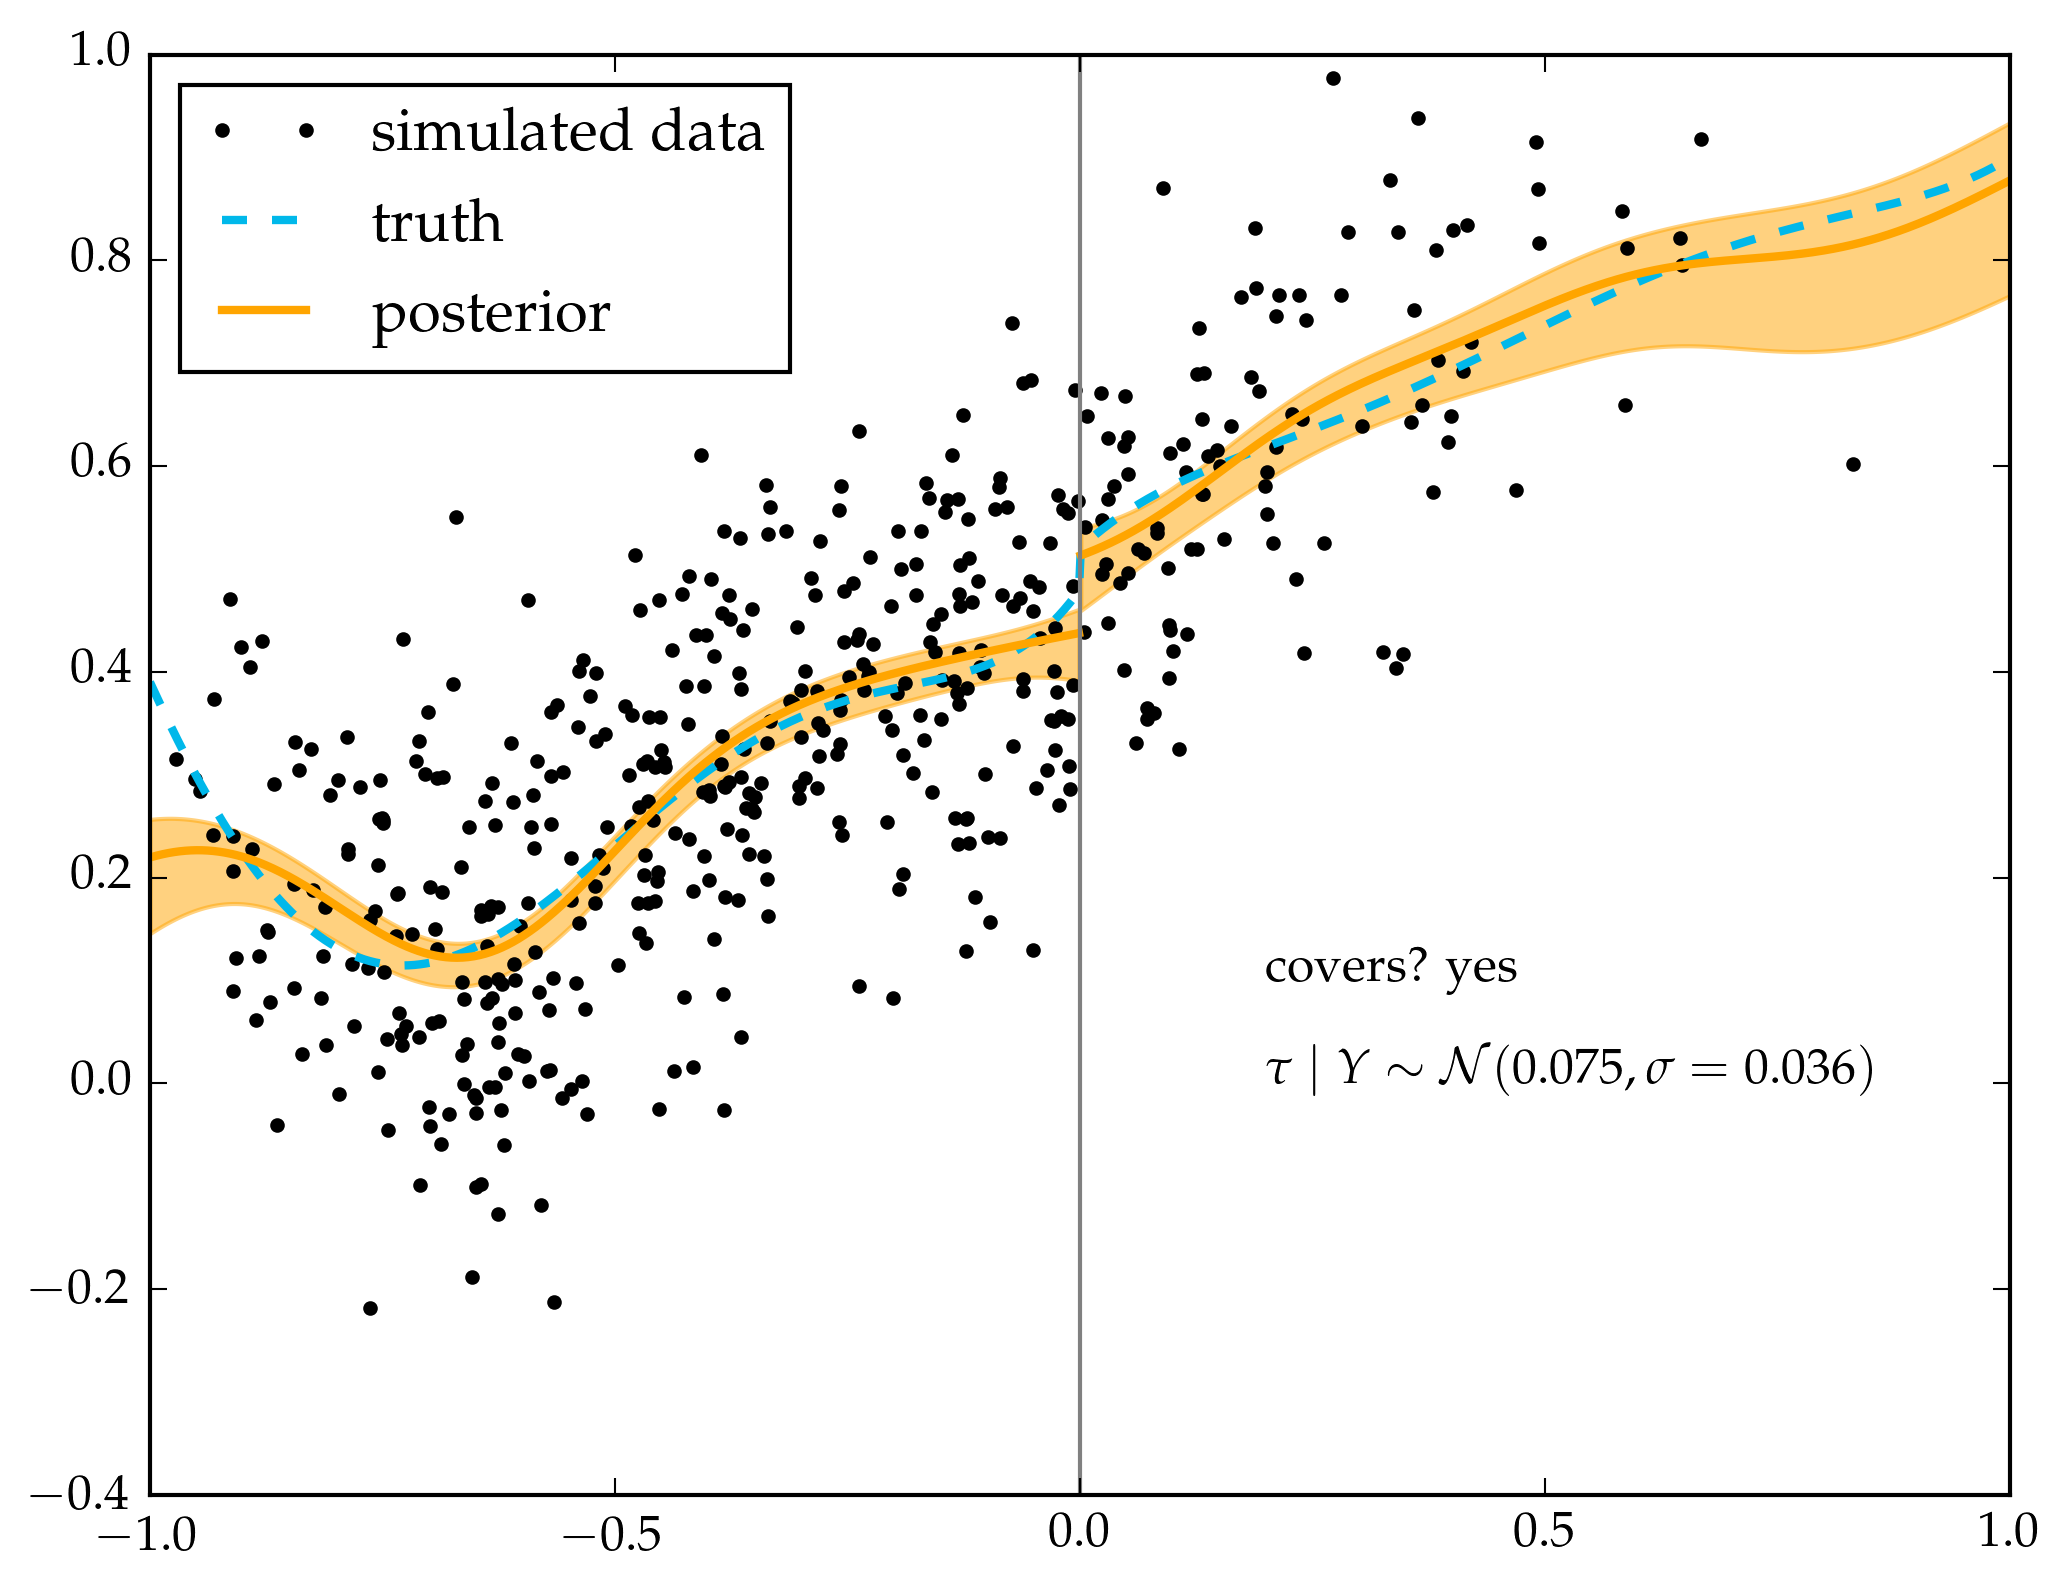

  3.302375 seconds (1.16 M allocations: 75.078 MB, 0.44% gc time)


In [37]:
@time plot_sim("lee", 2, 0.0);

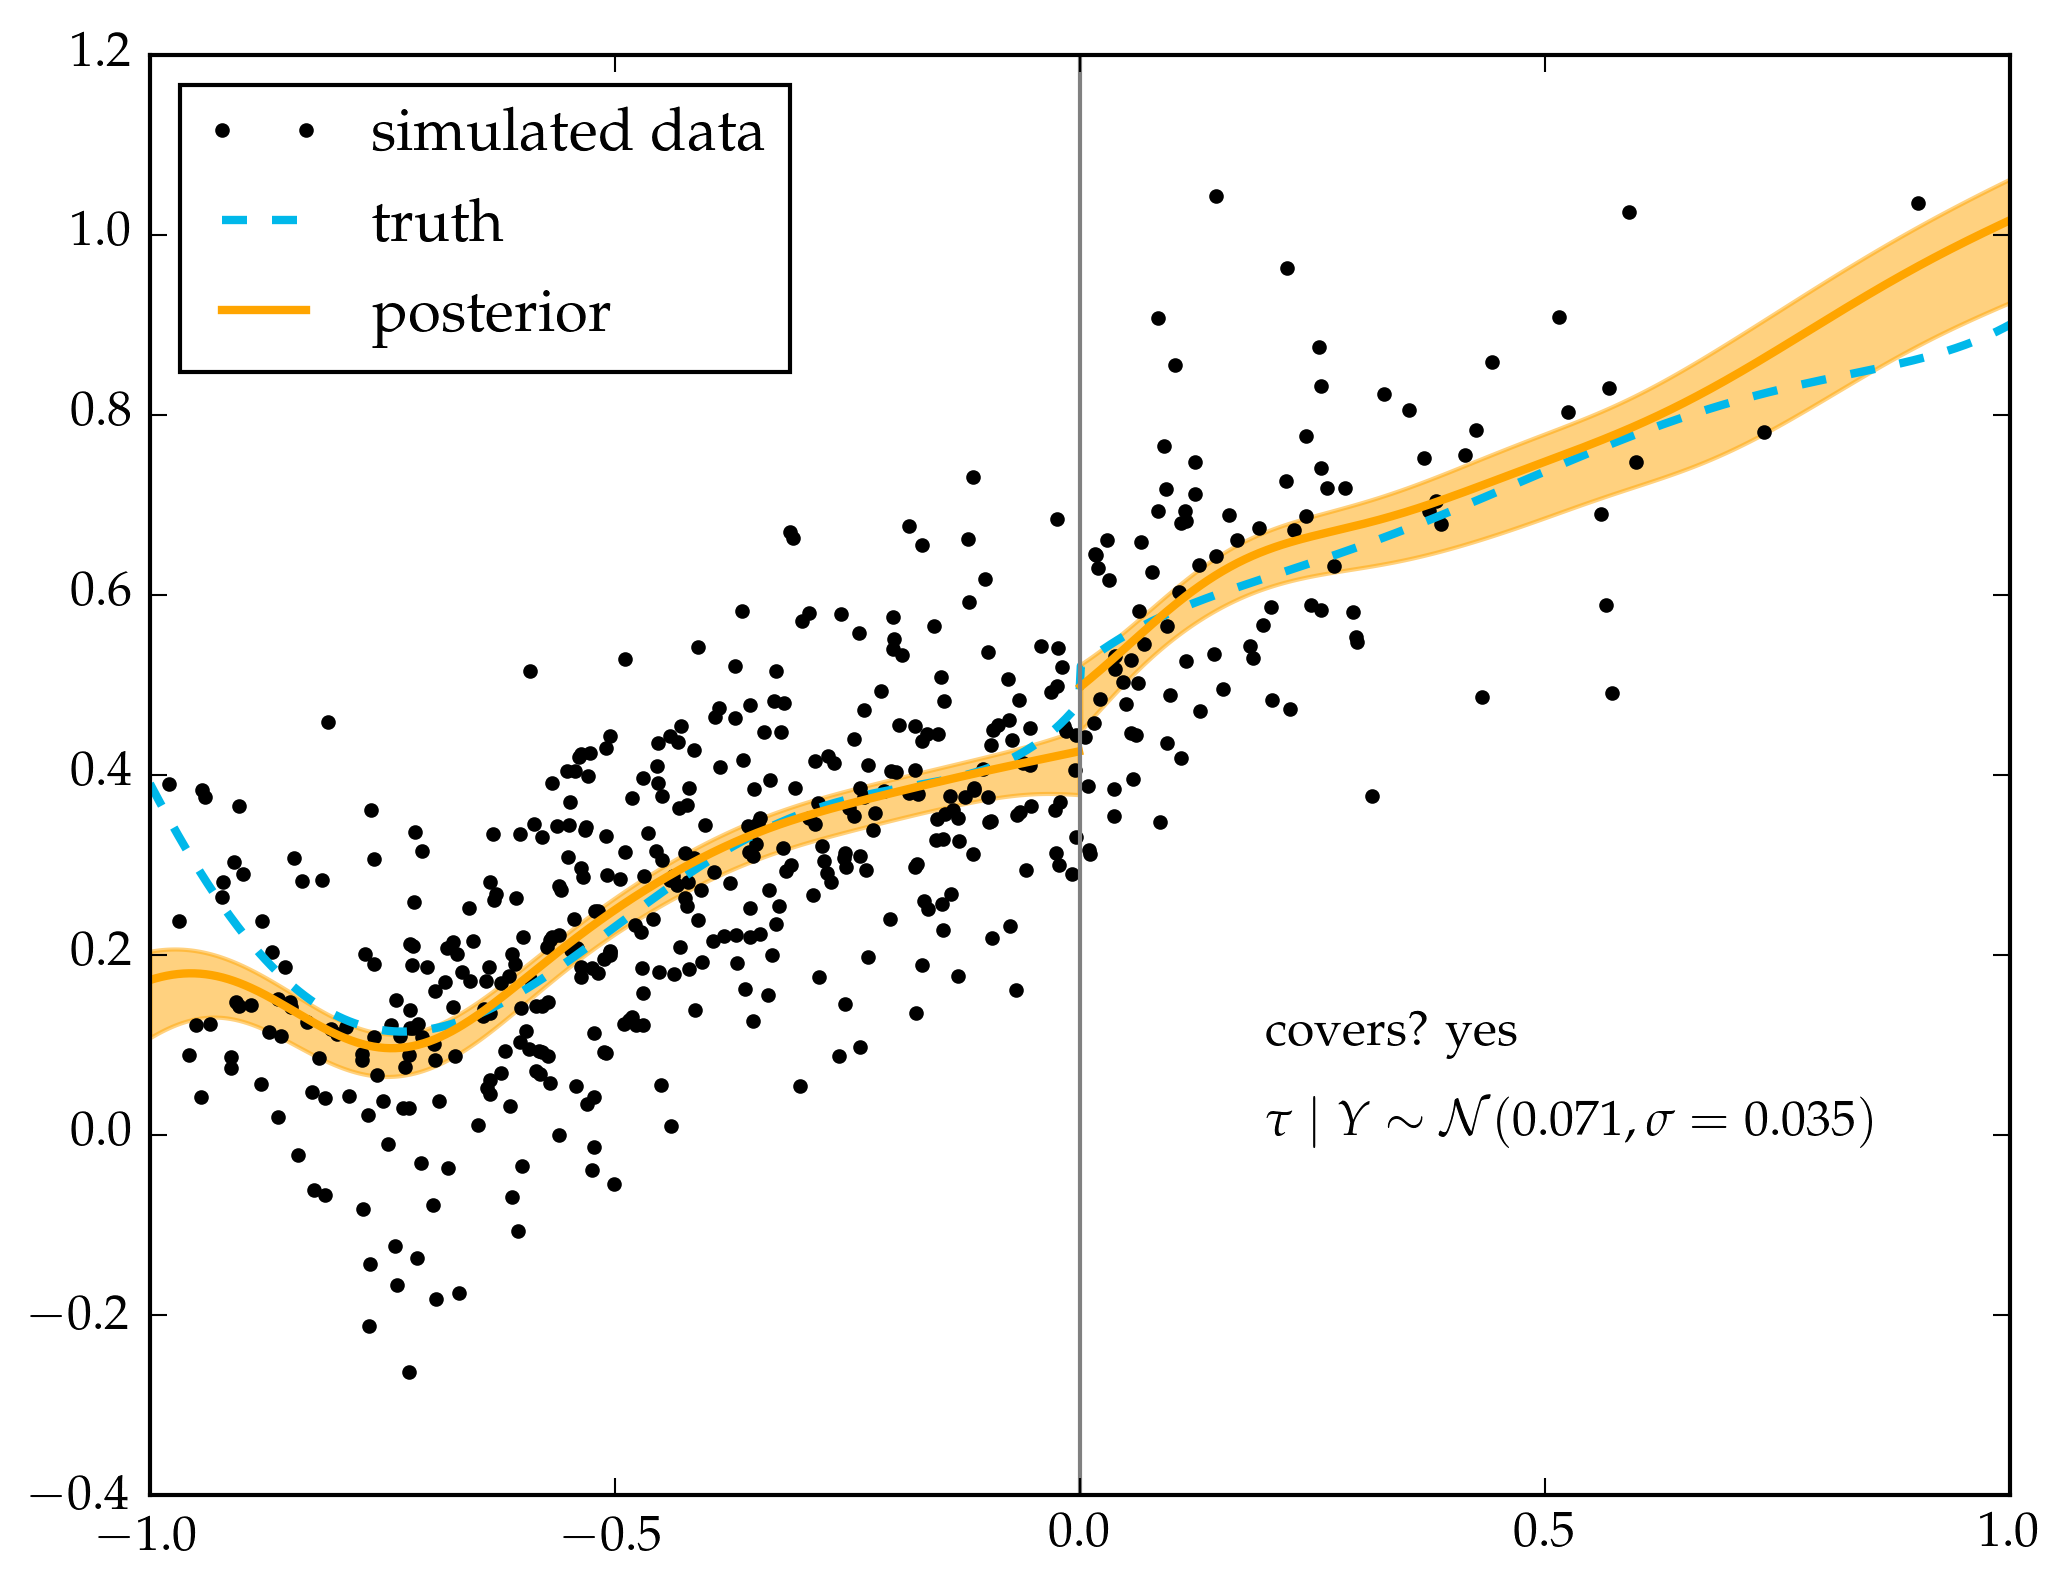

PyObject <matplotlib.text.Text object at 0x31fd1f190>

In [26]:
plot_sim("lee", 3, 0.0)

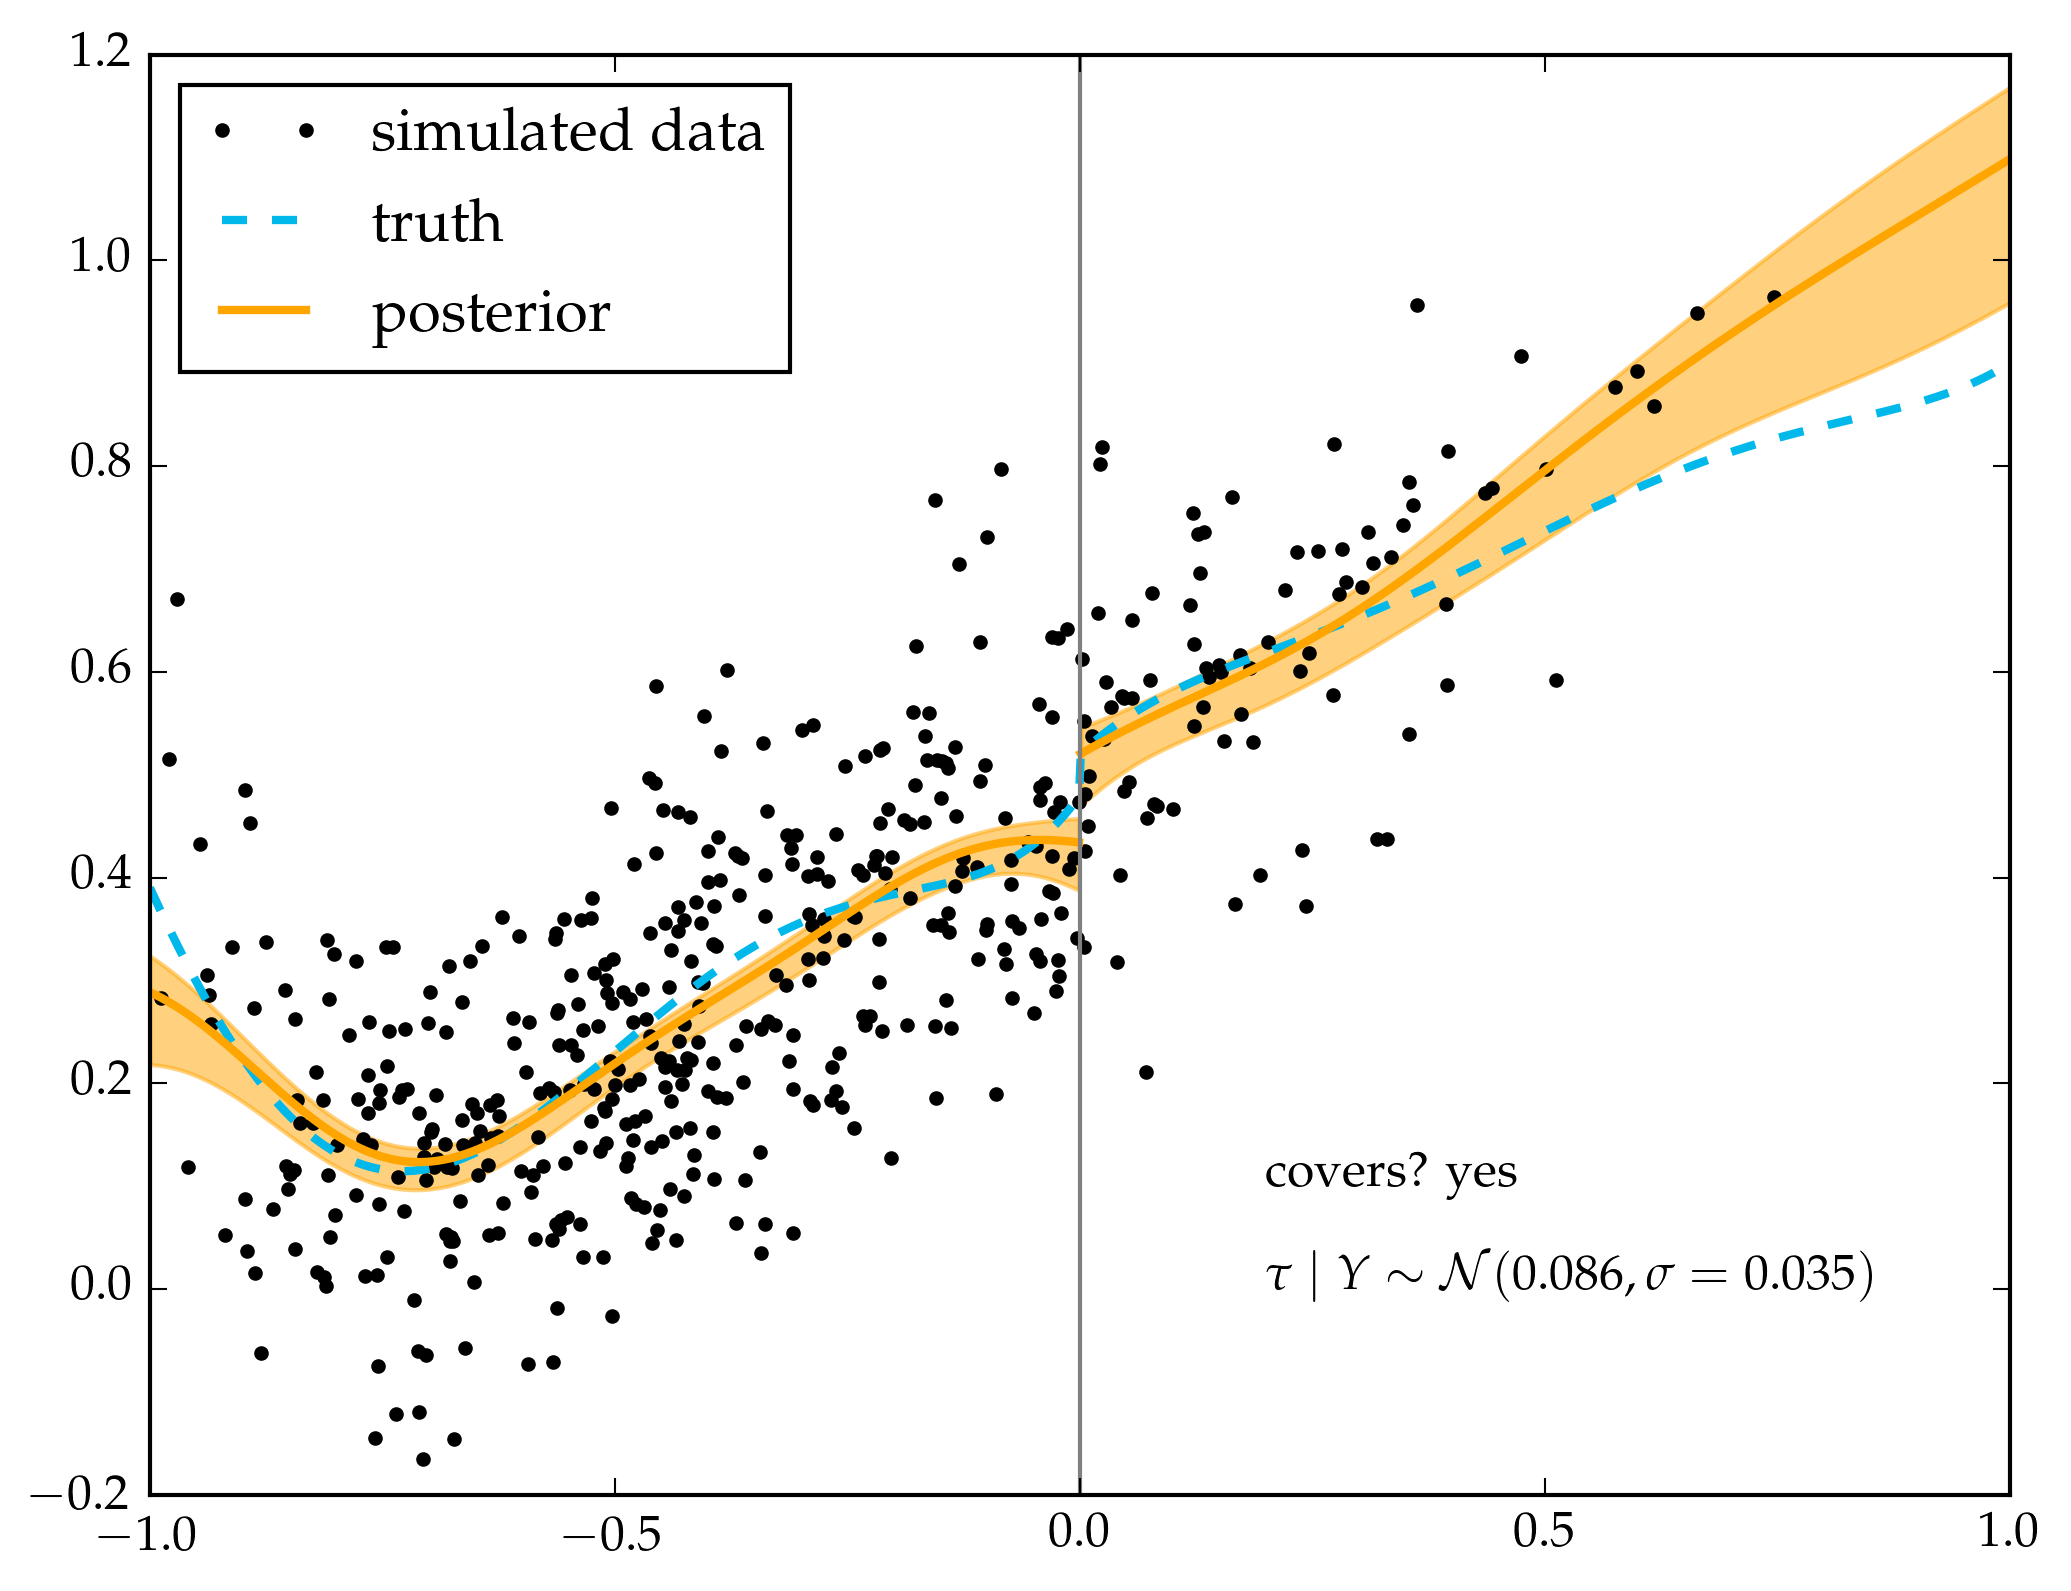

PyObject <matplotlib.text.Text object at 0x321f2f590>

In [27]:
plot_sim("lee", 4, 0.0)

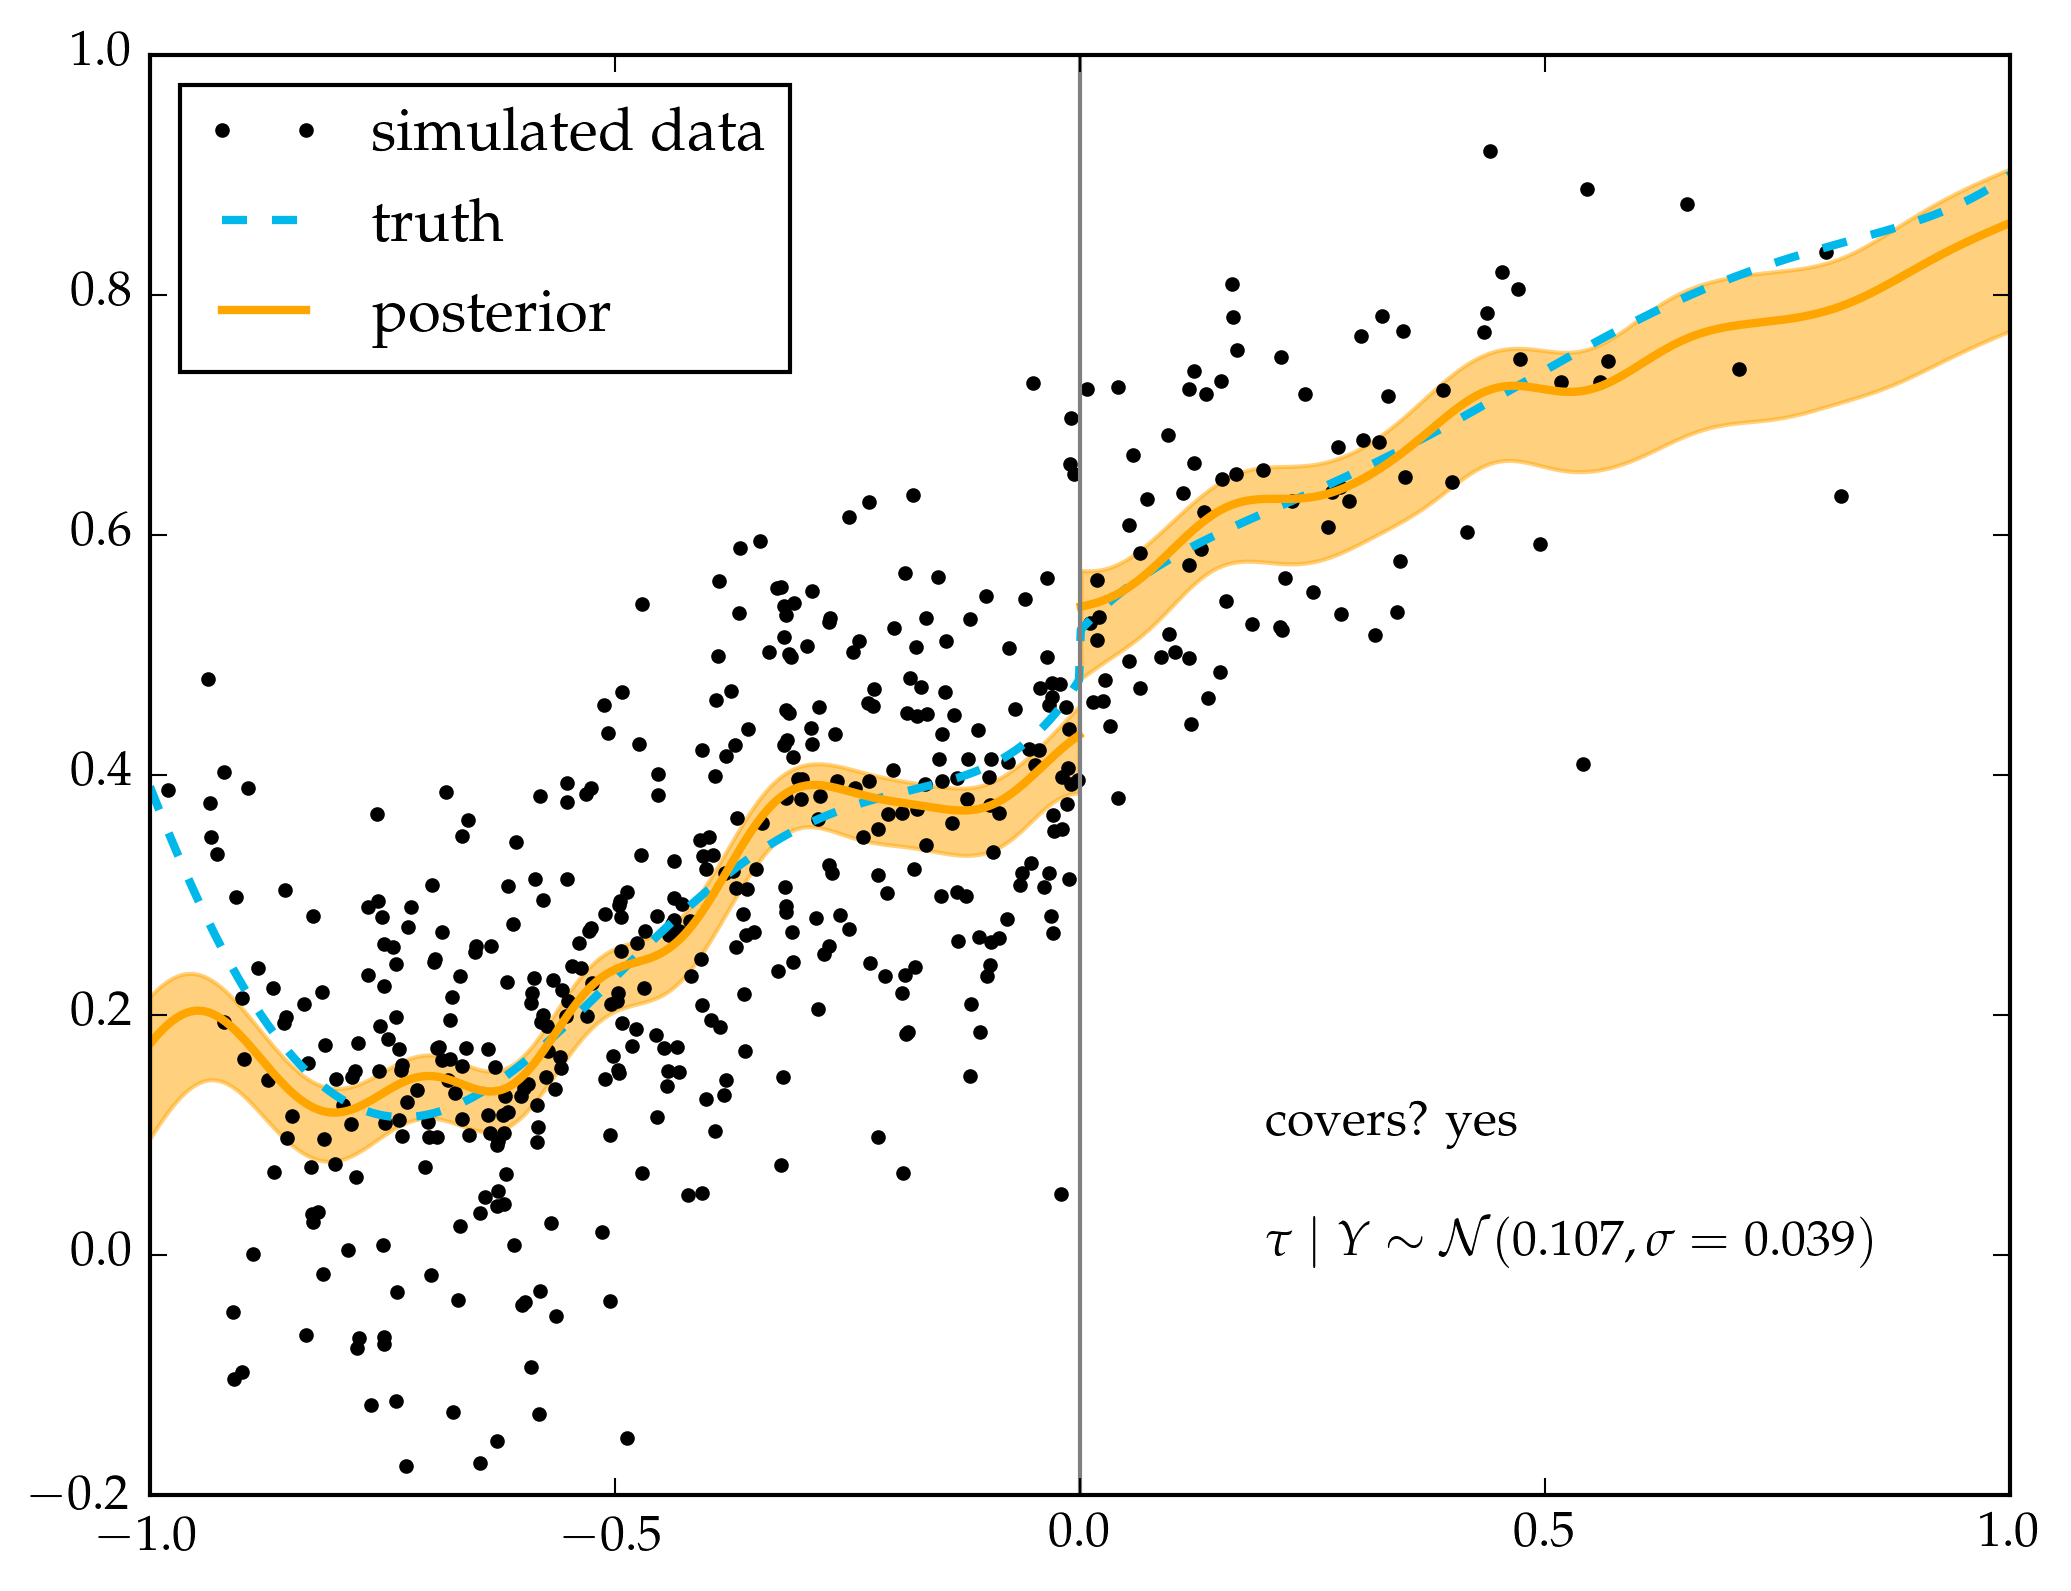

PyObject <matplotlib.text.Text object at 0x322642190>

In [28]:
plot_sim("lee", 5, 0.0)

## now do all of them

In [29]:
nsims = 1000
τtrue = lee_right(0.0)-lee_left(0.0)
lee_biases=Array(Float64, nsims)
lee_covers=Array(Bool, nsims)
lee_τpost = Array(Normal, nsims)
lee_hyps = Array(Float64, 7, nsims)
for isim in 1:nsims
    sim_result = do_sim("lee", isim, 0.0)
    τpost = sim_result.τpost
    cover = quantile(τpost, 0.025) < τtrue < quantile(τpost, 0.975)
    bias = mean(τpost)-τtrue
    
    lee_biases[isim] = bias
    lee_covers[isim] = cover
    lee_τpost[isim] = τpost
    lee_hyps[:,isim] = sim_result.hyp
end

In [30]:
_τpost = do_sim("lee", 5, 0.0).τpost
print(_τpost)
quantile(_τpost, 0.025) < τtrue < quantile(_τpost, 0.975)

Distributions.Normal{Float64}(μ=0.10652216462318254, σ=0.038764861700950566)

true

In [31]:
@printf("bias=%.3f", mean(lee_biases))

bias=0.044

In [32]:
@printf("RMSE=%.3f", √( mean(lee_biases.^2) ))

RMSE=0.058

In [33]:
@printf("%.1f%% coverage", mean(lee_covers)*100) # coverage

76.2% coverage

In [34]:
get_τpost_2GP(_simdata[:x].values, _simdata[:y].values, 0.0)

Distributions.Normal{Float64}(μ=0.10652216462318254, σ=0.038764861700950566)

## Distribution of fitted hyperparameters

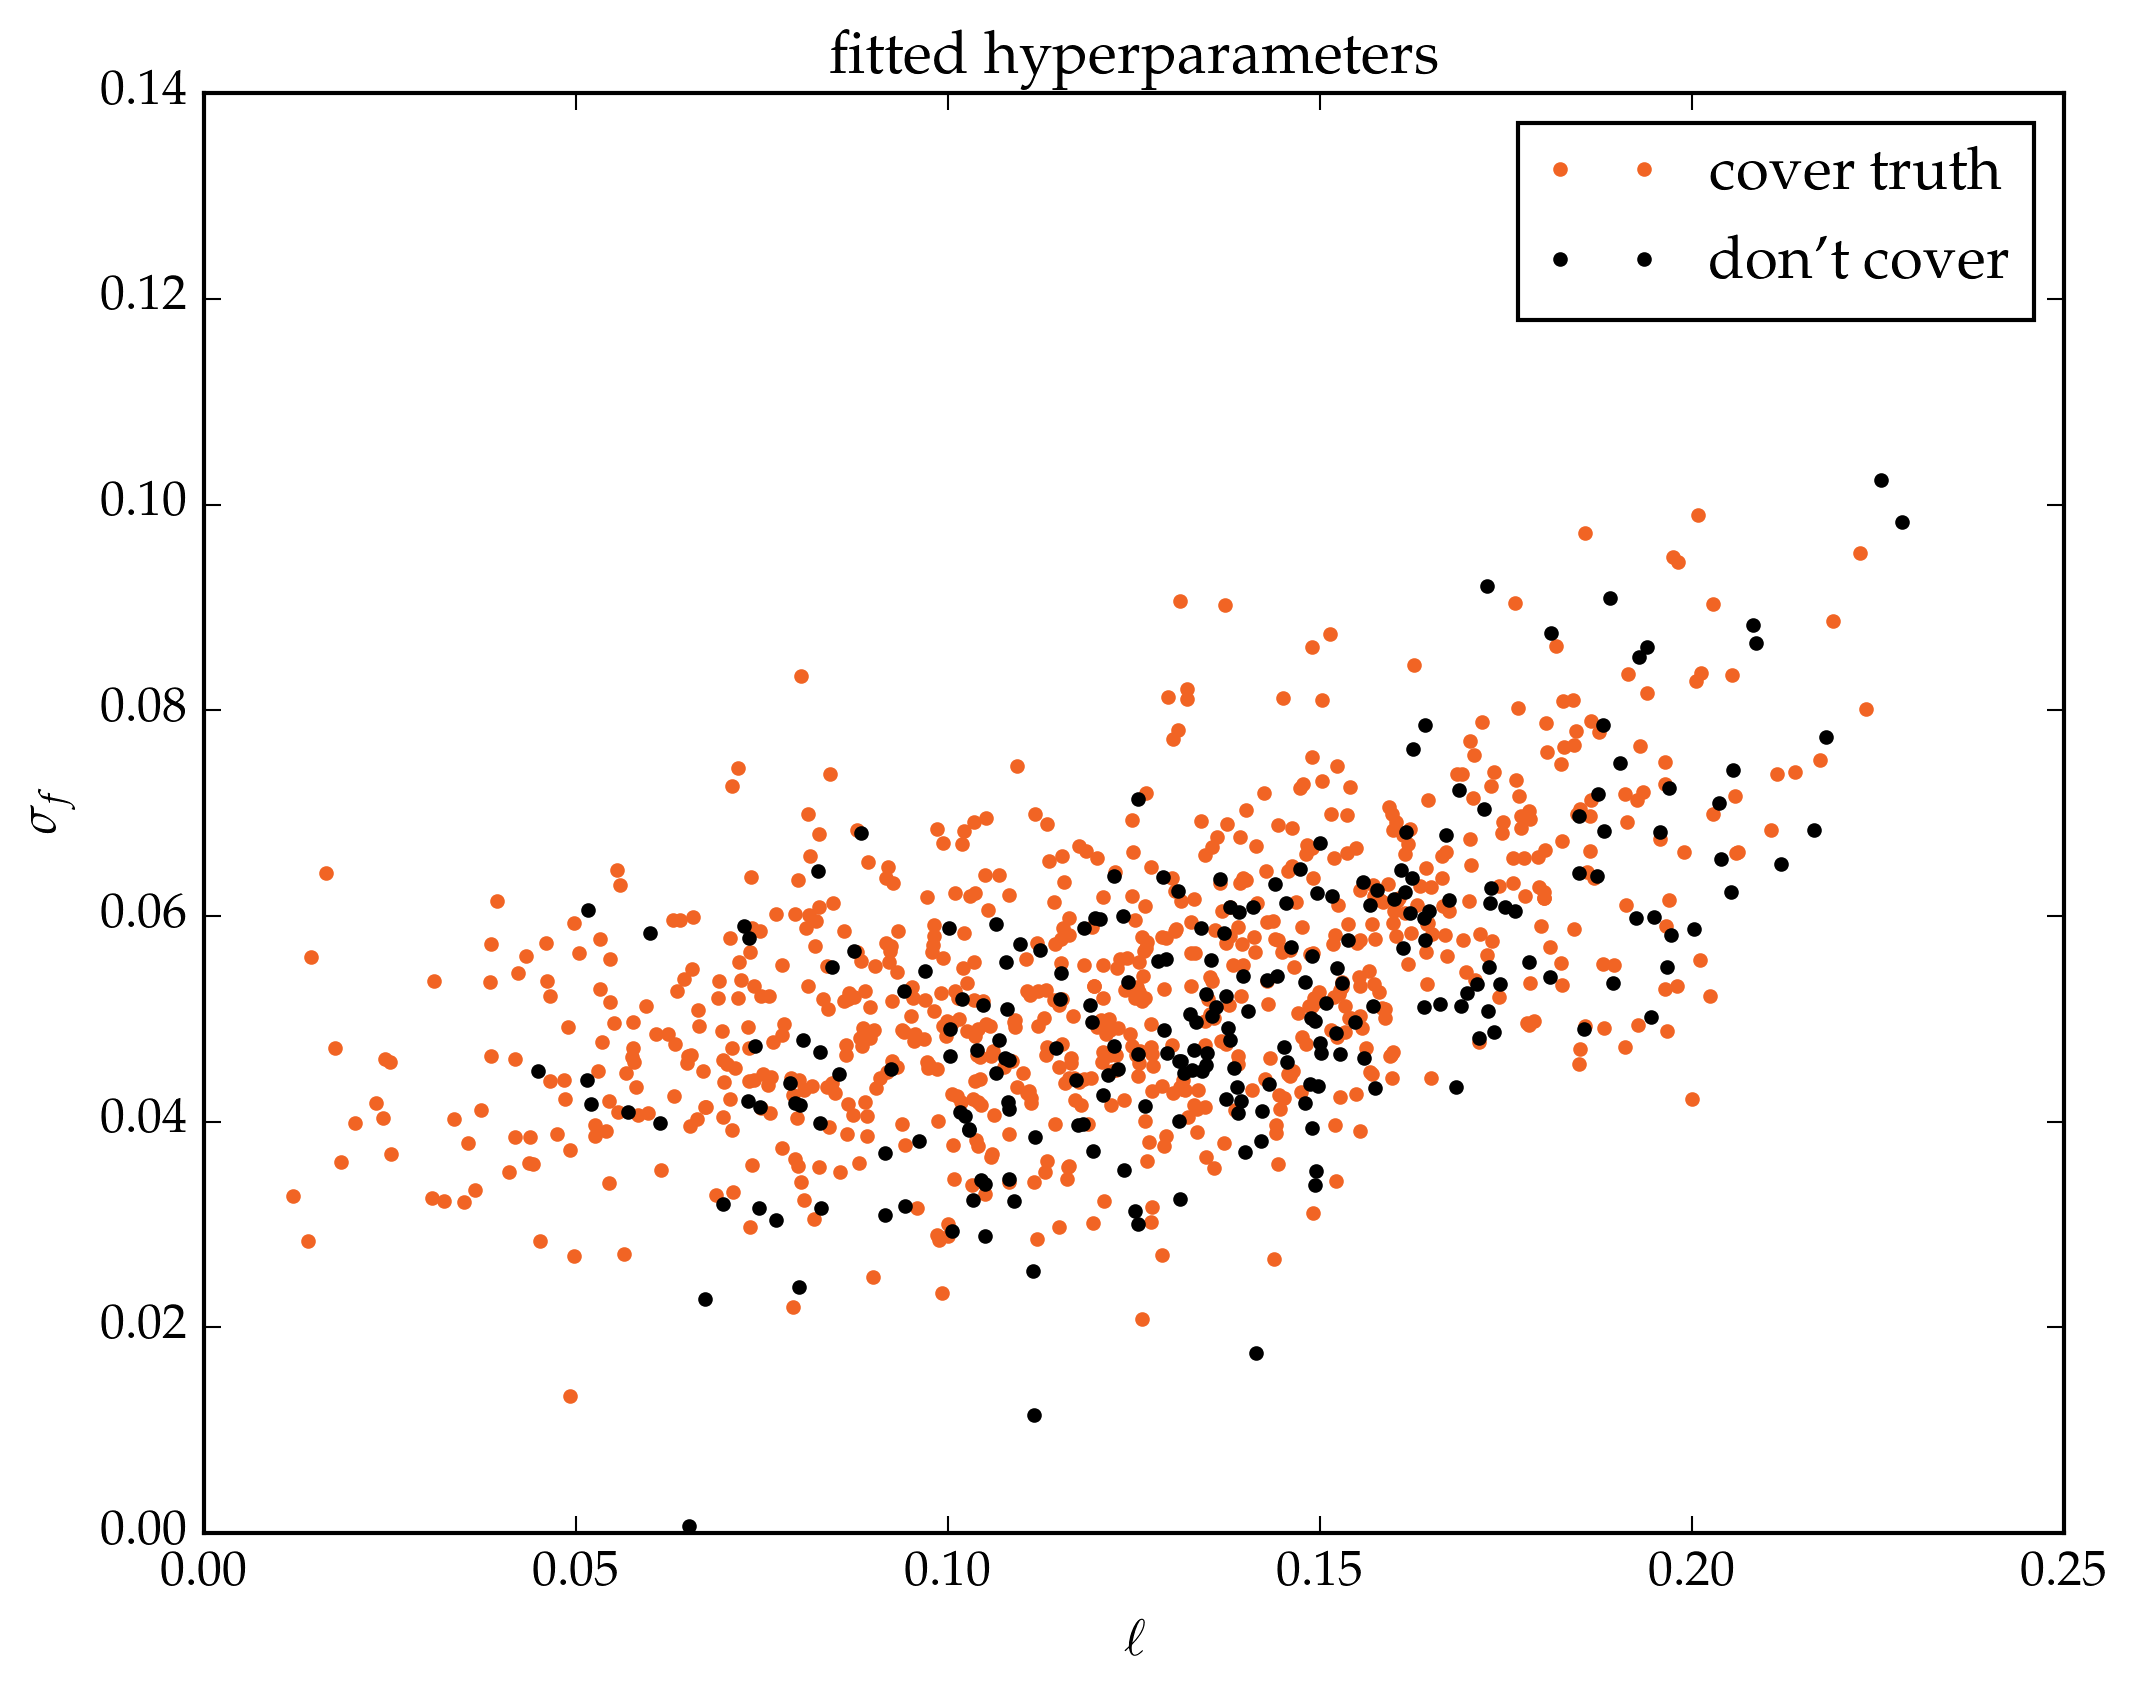

PyObject <matplotlib.legend.Legend object at 0x31f975690>

In [46]:
plt.plot(exp(lee_hyps[end-1,lee_covers]),  exp(lee_hyps[end,lee_covers]),  ".", color="#F16424", label="cover truth")
plt.plot(exp(lee_hyps[end-1,!lee_covers]), exp(lee_hyps[end,!lee_covers]), ".", color="black",   label="don't cover")
plt.xlabel(L"$\ell$")
plt.ylabel(L"$\sigma_f$")
plt.title("fitted hyperparameters")
plt.legend()

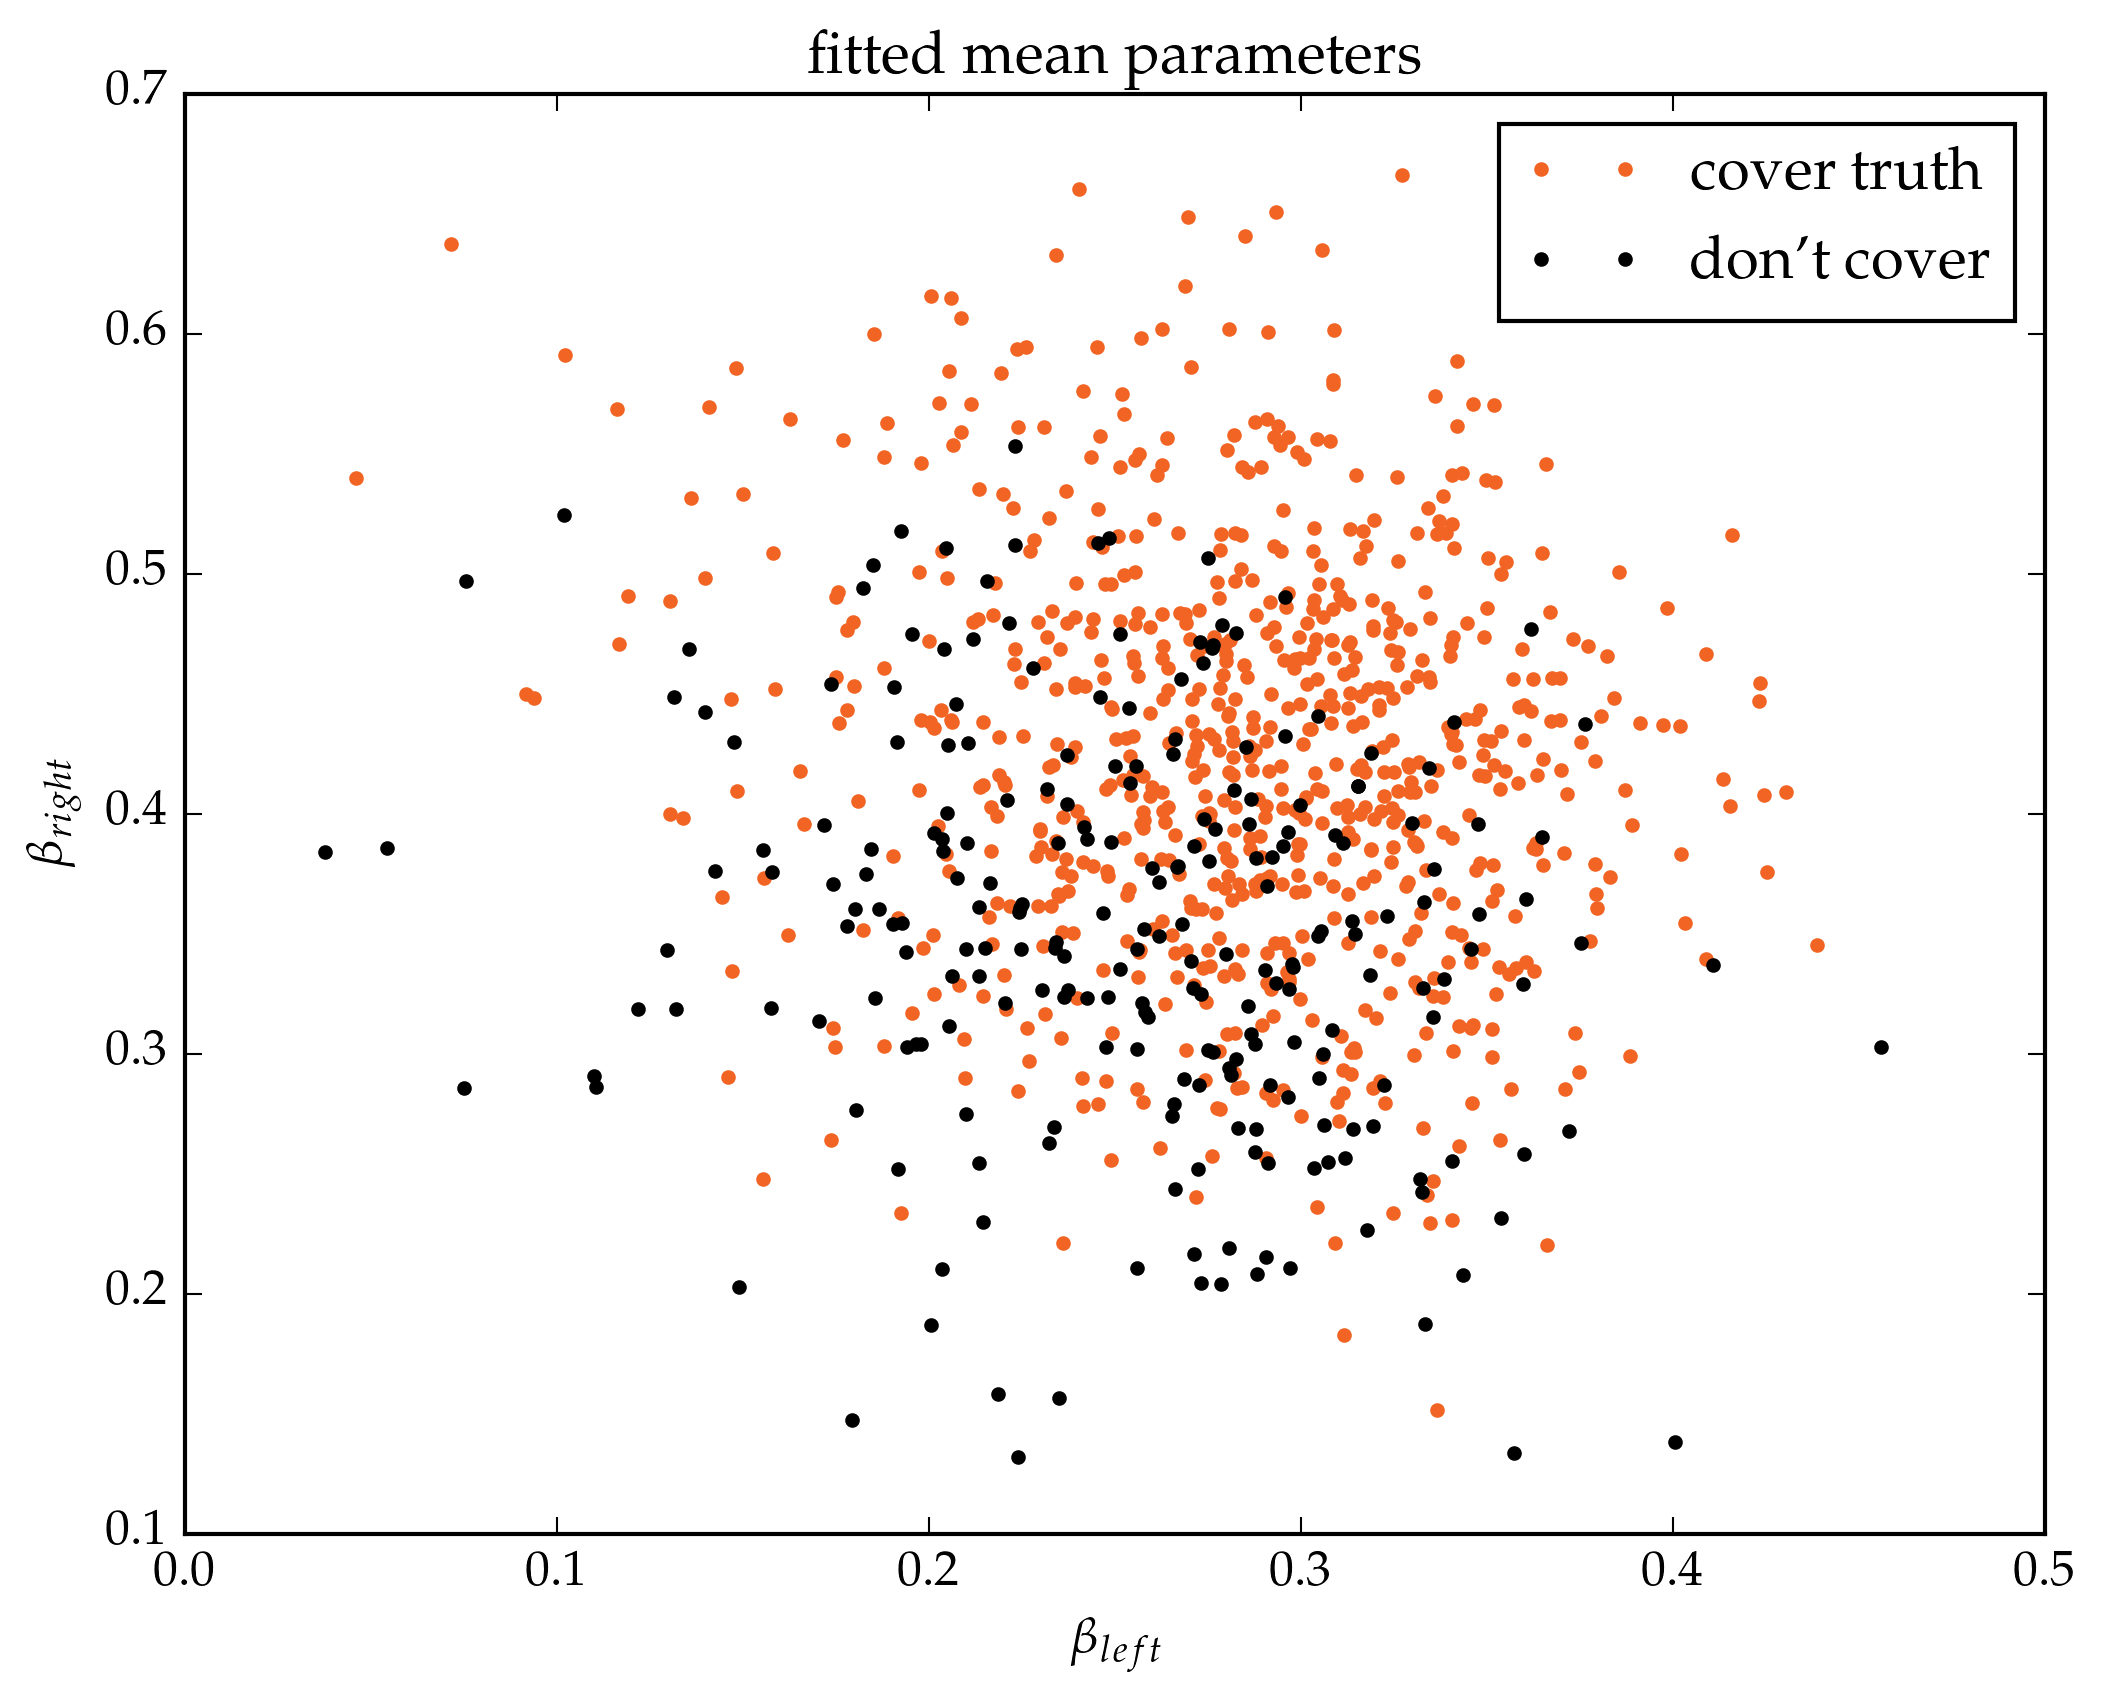

PyObject <matplotlib.legend.Legend object at 0x31fac70d0>

In [48]:
plt.plot(lee_hyps[2,lee_covers],  lee_hyps[4,lee_covers],  ".", color="#F16424", label="cover truth")
plt.plot(lee_hyps[2,!lee_covers], lee_hyps[4,!lee_covers], ".", color="black",   label="don't cover")
plt.xlabel(L"$\beta_{left}$")
plt.ylabel(L"$\beta_{right}$")
plt.title("fitted mean parameters")
plt.legend()

# Pushing the trend into the kernel

Besides the hyperparameters, another source of uncertainty that isn't being accounted for is the mean parameters $\mu$ and $\beta$ on either side of the discontinuity. In the full Bayesian approach, we can just put a prior on them, and carry through their uncertainty. In the optimization approach, what we can do is add the covariance induced by the prior on $\mu$ and $\beta$ to the covariance matrix. Their uncertainty is then propagated automatically by the Gaussian Process machinery.

In [89]:
using GaussianProcesses: Stationary, MatF64, VecF64, StationaryData, EmptyData
import GaussianProcesses: cov, cov!, addcov!, kernel_data_key, get_params, set_params!, get_param_names, num_params

In [109]:
type ConstantKernel <: Stationary
    σ2::Float64
    ConstantKernel(lσ::Float64) = new(exp(2*lσ))
end
function set_params!(k::ConstantKernel, hyp::Vector{Float64})
    k.σ2 = exp(2*hyp[1])
end
get_params(k::ConstantKernel) = [0.5*log(k.σ2)]
get_param_names(::ConstantKernel) = [:lσ]
GaussianProcesses.num_params(k::ConstantKernel) = 1
GaussianProcesses.kernel_data_key{M<:MatF64}(k::ConstantKernel, X::M) = :ConstData
cov(k::ConstantKernel, r::Float64) = k.σ2
cov{V1<:VecF64,V2<:VecF64}(k::ConstantKernel, x::V1, y::V2) = k.σ2

@inline function dk_dθp(k::ConstantKernel, r::Float64, p::Int)
    if p==1
        return dk_dlσ(se, r)
    else
        return NaN
    end
end
distance{M<:MatF64}(k::ConstantKernel, X::M) = ones(Float64, size(X,2), size(X,2))
distance{M1<:MatF64,M2<:MatF64}(k::ConstantKernel, X::M1, Y::M2) = ones(Float64, size(X,2), size(Y,2))
distance{V1<:VecF64,V2<:VecF64}(k::ConstantKernel, x::V1, y::V2) = 1.0
function GaussianProcesses.cov!{M<:MatF64}(cK::MatF64, k::ConstantKernel, X::M, data::EmptyData)
    fill!(cK, k.σ2)
end
function GaussianProcesses.addcov!{M<:MatF64}(cK::MatF64, k::ConstantKernel, X::M, data::EmptyData)
    cK[:,:] += k.σ2
end   

In [186]:
function fit_2GP_meankern(x::Vector, y::Vector, thresh::Real)
    # specify kernel and mean function
    kern = SEIso(-3.0, -3.0) + fix(ConstantKernel(3.0)+LinIso(-3.0))
    right = x .> thresh
    meanf_l = MeanZero()
    meanf_r = MeanZero()
    
    # create GPs for left and right
    gp_left  =GP(x[!right]', y[!right], meanf_l, kern, 0.0)
    gp_right =GP(x[right]',  y[right],  meanf_r, kern, 0.0)
    both_gps = GeoRDD.GPRealisations([gp_left, gp_right])
    
    # optimize hyperparameters
    optimize!(both_gps, mean=false)
    return both_gps
end

fit_2GP_meankern (generic function with 1 method)

In [187]:
_both_gps=fit_2GP_meankern(_simdata[:x].values, _simdata[:y].values, 0.0)

GeoRDD.GPRealisations(GaussianProcesses.GP[GP object:
  Dim = 1
  Number of observations = 416
  Mean function:
    Type: GaussianProcesses.MeanConst, Params: [0.0]
  Kernel:
    Type: GaussianProcesses.SumKernel
      Type: GaussianProcesses.SEIso, Params: [-2.50381,-2.81622]
      Type: GaussianProcesses.FixedKern, Params: Float64[]
  Input observations = 
[-0.980896 -0.937369 … -0.00681883 -0.00217726]
  Output observations = [0.386936,0.479321,0.376609,0.348104,0.334052,0.194024,0.401803,-0.0481022,-0.103552,0.298374  …  0.456425,0.375832,0.405334,0.438114,0.313108,0.658657,0.392569,0.696798,0.650467,0.395658]
  Variance of observation noise = 0.01538777516847921
  Marginal Log-Likelihood = 242.544,GP object:
  Dim = 1
  Number of observations = 84
  Mean function:
    Type: GaussianProcesses.MeanConst, Params: [0.0]
  Kernel:
    Type: GaussianProcesses.SumKernel
      Type: GaussianProcesses.SEIso, Params: [-2.50381,-2.81622]
      Type: GaussianProcesses.FixedKern, Params: Float

In [188]:
function do_sim(sim::String, isim::Int, thresh::Real, method::Symbol)
    simdata=readtable(@sprintf("saved_simData/%s_%d.csv", sim, isim), header=true, names=[:i,:x,:y]);
    if method == :fixedmean
        both_gps = fit_2GP(simdata[:x].values, simdata[:y].values, thresh)
    elseif method == :meankern
        both_gps = fit_2GP_meankern(simdata[:x].values, simdata[:y].values, thresh)
    else
        throw(ArgumentError("invalid method"))
    end
    gp_left, gp_right = both_gps.reals
    τpost = get_τpost(gp_left, gp_right, thresh)
    if method == :fixedmean
        hyp = get_params(both_gps)
    elseif method == :meankern
        hyp = get_params(both_gps, mean=false)
    else
        throw(ArgumentError("invalid method"))
    end
    return Fitted2GP(τpost, hyp)
end

do_sim (generic function with 2 methods)

In [189]:
function plot_sim(sim::String, isim::Int, thresh::Real, method::Symbol)
    simdata=readtable(@sprintf("saved_simData/%s_%d.csv", sim, isim), header=true, names=[:i,:x,:y]);
    x = simdata[:x].values
    y = simdata[:y].values
    if method == :fixedmean
        both_gps = fit_2GP(simdata[:x].values, simdata[:y].values, thresh)
    elseif method == :meankern
        both_gps = fit_2GP_meankern(simdata[:x].values, simdata[:y].values, thresh)
    else
        throw(ArgumentError("invalid method"))
    end
    gp_left, gp_right = both_gps.reals
    τpost = get_τpost(gp_left, gp_right, thresh)
    xx=linspace(-1.0,1.0,1000)
    xx_left = xx[xx.<thresh]
    xx_right = xx[xx.>thresh]
    pred_left = predict(gp_left, xx_left'; full_cov=false)
    pred_right = predict(gp_right, xx_right'; full_cov=false)

    plt.plot(x, y, ".", color="black", label="simulated data")
    plt.plot(xx, lee_truth.(xx), "--", color="#00B8EA", linewidth=2, label="truth")
    plt.plot(xx_left, pred_left[1], 
        color="orange", linewidth=2, label="posterior")
    plt.fill_between(xx_left, pred_left[1].-2.0*√pred_left[2], pred_left[1].+√pred_left[2], 
        color="orange", alpha=0.5)
    plt.plot(xx_right, pred_right[1], color="orange", linewidth=2)
    plt.fill_between(xx_right, pred_right[1].-2.0*√pred_right[2], pred_right[1].+√pred_right[2], 
        color="orange", alpha=0.5)
    plt.axvline(0.0, color="grey")
    plt.legend(loc="upper left")
    plt.text(0.2, 0.0, latexstring(@sprintf("\$\\tau \\mid Y \\sim \\mathcal{N}(%.3f,\\sigma=%.3f)\$", mean(τpost), std(τpost))))
    cover = quantile(τpost, 0.025) < τtrue < quantile(τpost, 0.975)
    plt.text(0.2, 0.1, @sprintf("covers? %s", cover ? "yes" : "no"))
end

plot_sim (generic function with 2 methods)

Here's a cherry-picked example where the wider credible interval on the treatment effect now covers the truth.

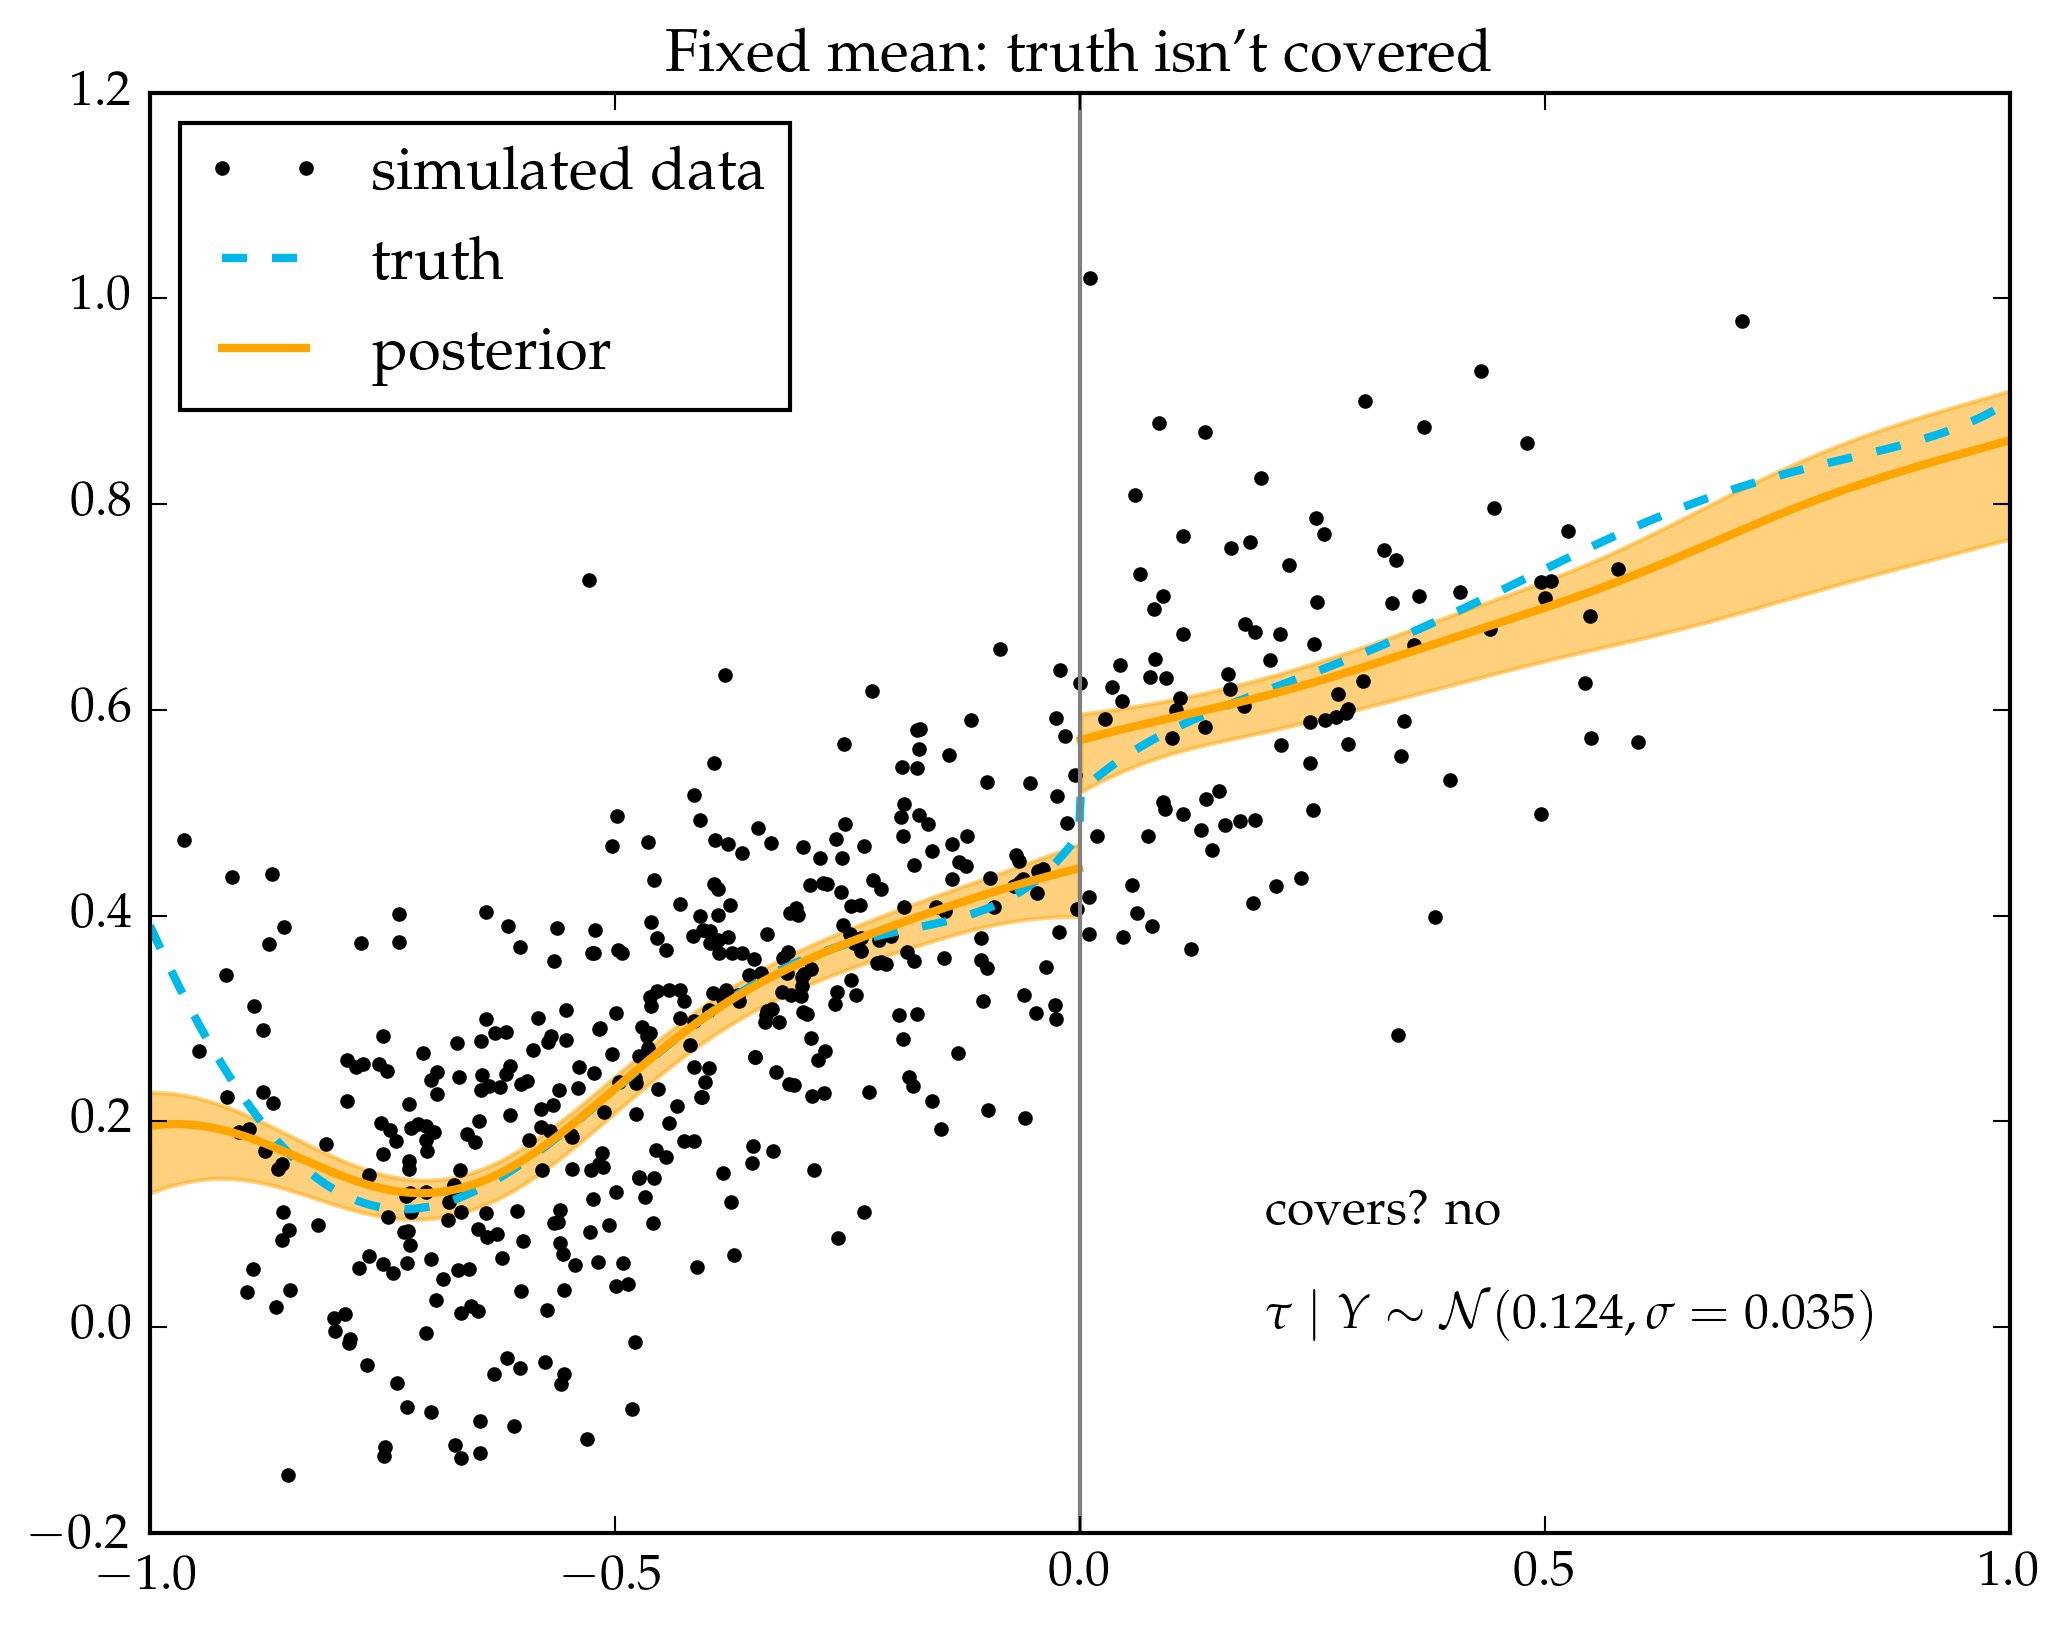

In [162]:
plot_sim("lee", 31, 0.0, :fixedmean)
plt.title("Fixed mean: truth isn't covered")
;

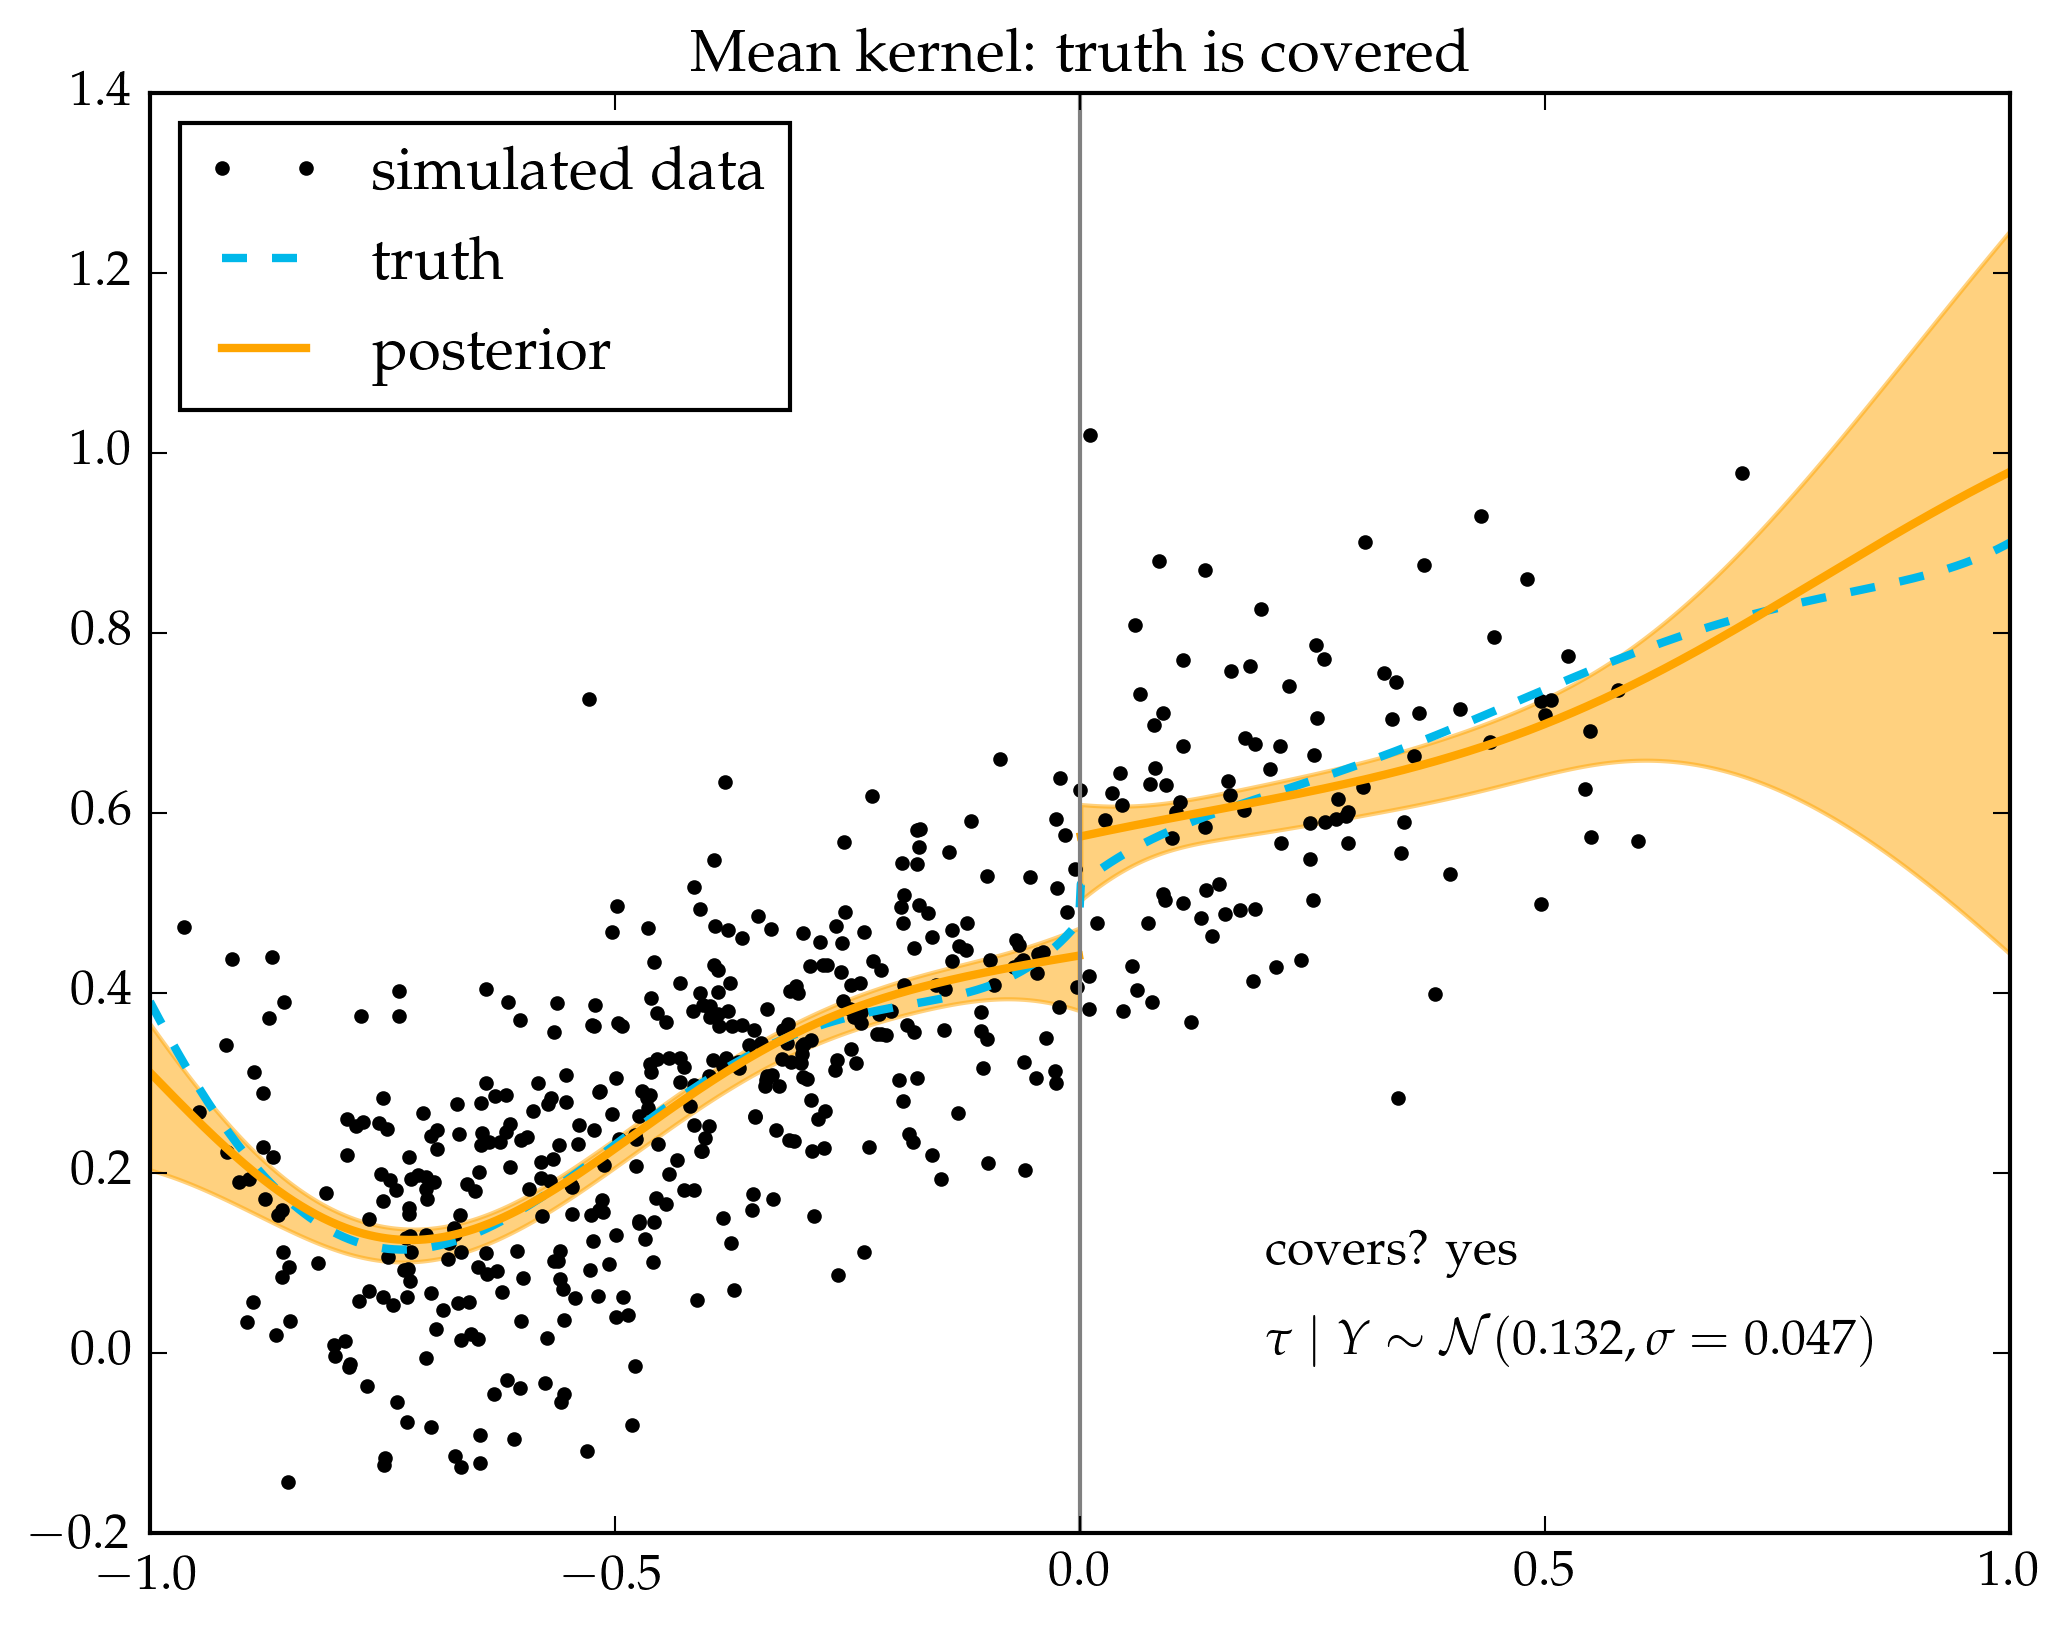

In [163]:
plot_sim("lee", 31, 0.0, :meankern)
plt.title("Mean kernel: truth is covered")
;

In [190]:
mk_lee_biases=Array(Float64, nsims)
mk_lee_covers=Array(Bool, nsims)
mk_lee_τpost = Array(Normal, nsims)
mk_lee_hyps = Array(Float64, 3, nsims)
for isim in 1:nsims
    if isim%10 == 0
        println(isim, "...")
    end
    sim_result = do_sim("lee", isim, 0.0, :meankern)
    τpost = sim_result.τpost
    cover = quantile(τpost, 0.025) < τtrue < quantile(τpost, 0.975)
    bias = mean(τpost)-τtrue
    
    mk_lee_biases[isim] = bias
    mk_lee_covers[isim] = cover
    mk_lee_τpost[isim] = τpost
    mk_lee_hyps[:,isim] = sim_result.hyp
end

10...
20...
30...
40...
50...
Base.LinAlg.PosDefException(3)
60...
70...
80...
90...
100...
Base.LinAlg.PosDefException(2)
110...
120...
130...
Base.LinAlg.PosDefException(3)
140...
Base.LinAlg.PosDefException(2)
150...
160...
170...
180...
190...
200...
Base.LinAlg.PosDefException(24)
210...
220...
230...
240...
Base.LinAlg.PosDefException(3)
250...
Base.LinAlg.PosDefException(54)
260...
Base.LinAlg.PosDefException(6)
Base.LinAlg.PosDefException(2)
270...
280...
290...
300...
310...
320...
330...
340...
350...
360...
370...
Base.LinAlg.PosDefException(3)
380...
390...
400...
410...
Base.LinAlg.PosDefException(3)
420...
Base.LinAlg.PosDefException(2)
430...
440...
450...
460...
Base.LinAlg.PosDefException(2)
470...
480...
490...
500...
510...
520...
Base.LinAlg.PosDefException(3)
530...
540...
550...
560...
Base.LinAlg.PosDefException(3)
Base.LinAlg.PosDefException(3)
570...
580...
590...
600...
Base.LinAlg.PosDefException(2)
610...
620...
630...
Base.LinAlg.PosDefException(2)
Base.Lin

In [192]:
@printf("bias=%.3f\n", mean(lee_biases))

@printf("RMSE=%.3f\n", √( mean(lee_biases.^2) ))

@printf("%.1f%% coverage\n", mean(lee_covers)*100) # coverage

bias=0.044
RMSE=0.058
76.2% coverage


In [193]:
@printf("bias=%.3f\n", mean(mk_lee_biases))

@printf("RMSE=%.3f\n", √( mean(mk_lee_biases.^2) ))

@printf("%.1f%% coverage\n", mean(mk_lee_covers)*100) # coverage

bias=0.044
RMSE=0.062
84.4% coverage
